# Imports

In [747]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# interpret_dftest written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline

In [7]:
data = pd.read_csv('./data/united_states_weekly_deaths.csv')
data.head(2)

,country,region,region_code,start_date,end_date,year,week,population,total_deaths,covid_deaths,expected_deaths
0,United States,Alabama,AL,2015-01-04,2015-01-10,2015,1,4903185,1169,0,TBC
1,United States,Alabama,AL,2015-01-11,2015-01-17,2015,2,4903185,1172,0,TBC


# Initial EDA

In [8]:
data.shape

(14500, 11)

In [9]:
data.dtypes

country            object
region             object
region_code        object
start_date         object
end_date           object
year                int64
week                int64
population          int64
total_deaths        int64
covid_deaths        int64
expected_deaths    object
dtype: object

In [10]:
data['start_date'] = pd.to_datetime(data['start_date'])
data['end_date'] = pd.to_datetime(data['end_date'])

In [11]:
data.dtypes

country                    object
region                     object
region_code                object
start_date         datetime64[ns]
end_date           datetime64[ns]
year                        int64
week                        int64
population                  int64
total_deaths                int64
covid_deaths                int64
expected_deaths            object
dtype: object

In [12]:
data.head(2)

,country,region,region_code,start_date,end_date,year,week,population,total_deaths,covid_deaths,expected_deaths
0,United States,Alabama,AL,2015-01-04,2015-01-10,2015,1,4903185,1169,0,TBC
1,United States,Alabama,AL,2015-01-11,2015-01-17,2015,2,4903185,1172,0,TBC


In [13]:
data.isnull().sum()

country            0
region             0
region_code        0
start_date         0
end_date           0
year               0
week               0
population         0
total_deaths       0
covid_deaths       0
expected_deaths    0
dtype: int64

In [14]:
data.shape

(14500, 11)

In [15]:
# drop non-useful columns
data.drop(columns=['covid_deaths','expected_deaths'], inplace = True)

In [ ]:
# NY includes NYC's data, so we'll use a mask to drop out NYC for purposes of tallying totals.
nyc = data[data['region_code'] == 'NYC']

In [67]:
# total US weekly deaths
us_tot = pd.DataFrame(data.drop(nyc.index).groupby(['start_date', 'end_date'])['total_deaths'].sum())

us_tot.reset_index(level=us_tot.index.names, inplace=True)

# Summing the population of each region together for total US population
us_tot['population'] = data.drop(nyc.index).groupby('region_code')['population'].mean().sum()

us_tot

,start_date,end_date,total_deaths,population
0,2015-01-04,2015-01-10,61737,328300544
1,2015-01-11,2015-01-17,61141,328300544
2,2015-01-18,2015-01-24,58628,328300544
3,2015-01-25,2015-01-31,57269,328300544
4,2015-02-01,2015-02-07,57284,328300544
...,...,...,...,...
274,2020-04-05,2020-04-11,73581,328300544
275,2020-04-12,2020-04-18,69533,328300544
276,2020-04-19,2020-04-25,63336,328300544
277,2020-04-26,2020-05-02,55506,328300544


In [68]:
# create deaths per million column
data['deaths_per_mil'] = round(data['total_deaths'] / ( data['population'] / 1_000_000 ), 3)
us_tot['deaths_per_mil'] = round(us_tot['total_deaths'] / ( us_tot['population'] / 1_000_000 ), 3)

In [82]:
data

,country,region,region_code,start_date,end_date,year,week,population,total_deaths,deaths_per_mil
0,United States,Alabama,AL,2015-01-04,2015-01-10,2015,1,4903185,1169,238.416
1,United States,Alabama,AL,2015-01-11,2015-01-17,2015,2,4903185,1172,239.028
2,United States,Alabama,AL,2015-01-18,2015-01-24,2015,3,4903185,1072,218.633
3,United States,Alabama,AL,2015-01-25,2015-01-31,2015,4,4903185,1087,221.693
4,United States,Alabama,AL,2015-02-01,2015-02-07,2015,5,4903185,1130,230.462
...,...,...,...,...,...,...,...,...,...,...
14495,United States,New York,NY,2020-04-05,2020-04-11,2020,15,19453561,12079,620.915
14496,United States,New York,NY,2020-04-12,2020-04-18,2020,16,19453561,9864,507.054
14497,United States,New York,NY,2020-04-19,2020-04-25,2020,17,19453561,7123,366.154
14498,United States,New York,NY,2020-04-26,2020-05-02,2020,18,19453561,5109,262.625


In [69]:
us_tot

,start_date,end_date,total_deaths,population,deaths_per_mil
0,2015-01-04,2015-01-10,61737,328300544,188.050
1,2015-01-11,2015-01-17,61141,328300544,186.235
2,2015-01-18,2015-01-24,58628,328300544,178.580
3,2015-01-25,2015-01-31,57269,328300544,174.441
4,2015-02-01,2015-02-07,57284,328300544,174.486
...,...,...,...,...,...
274,2020-04-05,2020-04-11,73581,328300544,224.127
275,2020-04-12,2020-04-18,69533,328300544,211.797
276,2020-04-19,2020-04-25,63336,328300544,192.921
277,2020-04-26,2020-05-02,55506,328300544,169.071


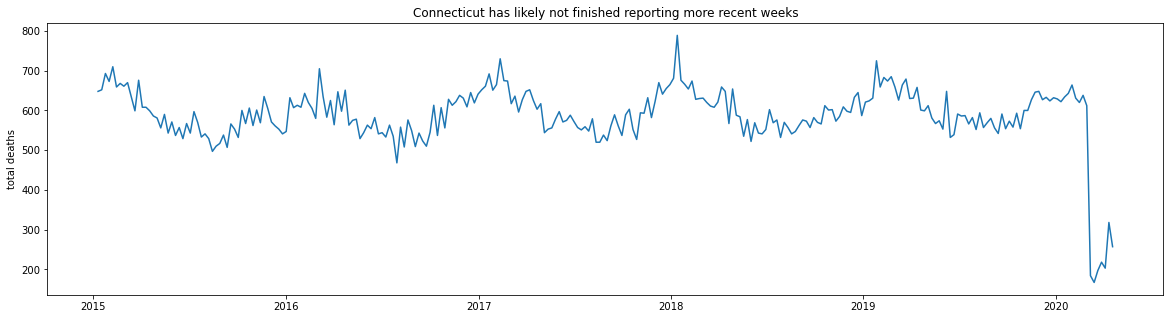

In [529]:
# Connecticut's data seems incomplete

plt.figure(figsize = (20,5))

sb.lineplot(data[data['region']=='Connecticut']['end_date'], data[data['region']=='Connecticut']['total_deaths'])
plt.yticks=data[data['region']=='Connecticut']['end_date'].dt.year
plt.title("Connecticut has likely not finished reporting more recent weeks")
plt.ylabel('total deaths')
plt.xlabel('');

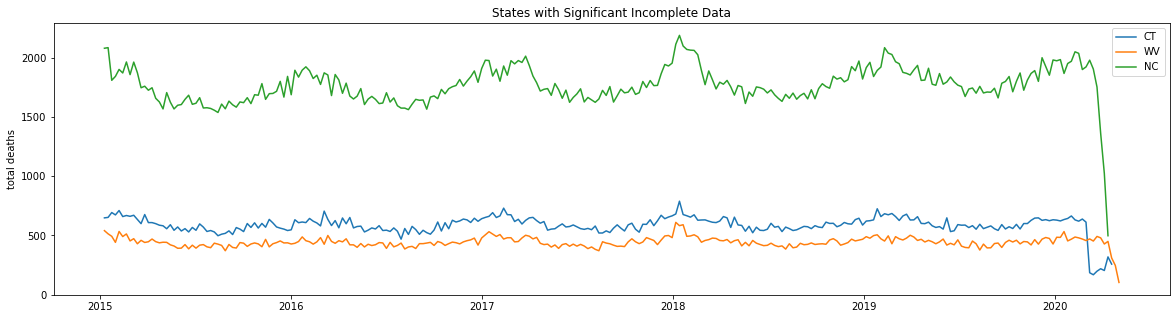

In [530]:
# Other states are missing data as well

plt.figure(figsize = (20,5))

sb.lineplot(data[data['region']=='Connecticut']['end_date'], data[data['region']=='Connecticut']['total_deaths'])
sb.lineplot(data[data['region']=='West Virginia']['end_date'], data[data['region']=='West Virginia']['total_deaths'])
sb.lineplot(data[data['region']=='North Carolina']['end_date'], data[data['region']=='North Carolina']['total_deaths'])
plt.yticks=data[data['region']=='Connecticut']['end_date'].dt.year
plt.xlabel('')
plt.ylabel('total deaths')
plt.title('States with Significant Incomplete Data')
plt.legend(['CT','WV','NC']);

## Data organization

In [70]:
# Simplify to a crosstab of state by week showing deaths per million
df = data.groupby(['region_code', 'end_date'])['deaths_per_mil'].mean().unstack()

In [339]:
# We know 2020's data will be aberrant (or believe it will be), so will train and validate our model on all data before then
# This model will presumably predict 2020 quite poorly; the degree by which it does is our parameter of interest.

test = df.T[df.columns.year == 2020].T
train = df.T[df.columns.year != 2020].T

us_train = us_tot[us_tot['start_date'].dt.year != 2020]
us_test = us_tot[us_tot['start_date'].dt.year == 2020]

# Using US totals to get parameters for a SARIMA model
First, check stationarity of state numbers.

## Dickey-Fuller tests

In [340]:
df_dickeys = pd.DataFrame()
train_dickeys = pd.DataFrame()
test_dickeys = pd.DataFrame()

for state in df.index:
    df_dickeys[state] = interpret_dftest(adfuller(df.loc[state,:].dropna()))
    
for state in train.index:
    train_dickeys[state] = interpret_dftest(adfuller(train.loc[state,:].dropna()))
    
for state in test.index:
    test_dickeys[state] = interpret_dftest(adfuller(test.loc[state,:].dropna()))
    
    

train_dickeys.T[train_dickeys.T['p-value'] > 0.01]
# Most are stationary, but there is variability

,Test Statistic,p-value
AZ,-3.305209,0.014647
FL,-2.818836,0.055633
GA,-3.421682,0.010242
KS,-3.184181,0.020919
MN,-3.173855,0.021549
ND,-3.401563,0.010906
NM,-3.369659,0.012038
NV,-3.420847,0.010268
OH,-3.071547,0.028732
OK,-3.213938,0.019192


Since some states seem to have some particular trend separate from others, separate models should be fit for each state to predict for each.  For the sake of consistency, a single set of parameters will be decided on by examining US data as a whole, opting for the best performing set of parameters that contains at least one differencing variable to account for states like Florida that may have trend.

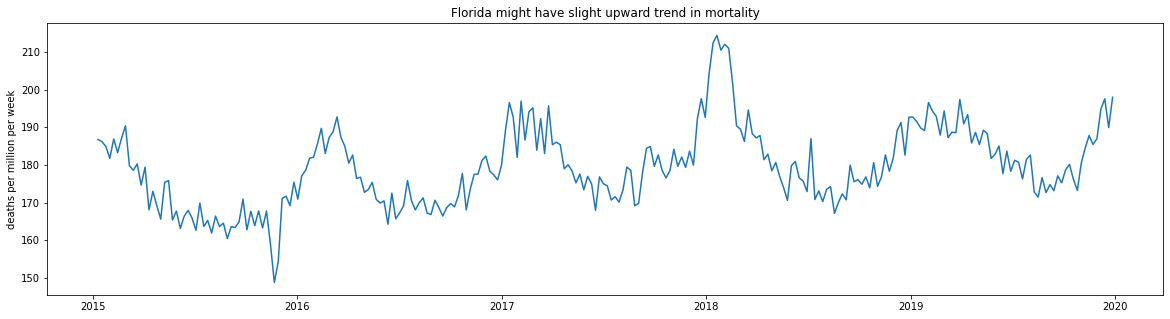

In [508]:
plt.figure(figsize = (20, 5))
plt.plot(train.loc['FL',:])
plt.ylabel('deaths per million per week')
plt.title('Florida might have slight upward trend in mortality');

## EDA

## US Weekly Mortality, pre-2020

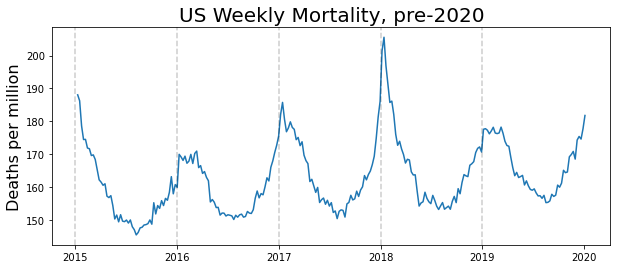

In [531]:

start_year = us_train['start_date'][0].year
end_year = us_train['end_date'][us_train.shape[0]-1].year

plt.figure(figsize=(10,4))
plt.plot(us_train.set_index('end_date')['deaths_per_mil'])
plt.title('US Weekly Mortality, pre-2020', fontsize=20)
plt.ylabel('Deaths per million', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Data dips

In [791]:
us_test

,start_date,end_date,total_deaths,population,deaths_per_mil
261,2020-01-05,2020-01-11,59967,328300544,182.659
262,2020-01-12,2020-01-18,58458,328300544,178.062
263,2020-01-19,2020-01-25,57889,328300544,176.329
264,2020-01-26,2020-02-01,57439,328300544,174.959
265,2020-02-02,2020-02-08,58118,328300544,177.027
266,2020-02-09,2020-02-15,57460,328300544,175.023
267,2020-02-16,2020-02-22,57485,328300544,175.099
268,2020-02-23,2020-02-29,57821,328300544,176.122
269,2020-03-01,2020-03-07,57547,328300544,175.288
270,2020-03-08,2020-03-14,56262,328300544,171.373


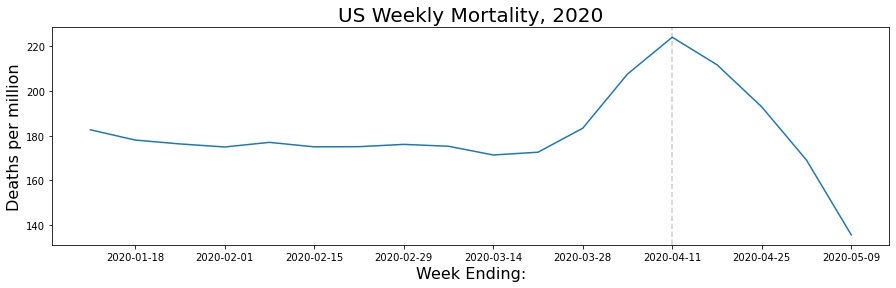

In [816]:
# the drop in recent data suggests that the data is incomplete

plt.figure(figsize=(15,4))
plt.plot(us_test.set_index('end_date')['deaths_per_mil'])
plt.title('US Weekly Mortality, 2020', fontsize=20)
plt.ylabel('Deaths per million', fontsize=16)
plt.xlabel('Week Ending:', fontsize=16)
plt.xticks(us_test.set_index('end_date').index[1::2])
plt.axvline(pd.to_datetime('2020-04-11'), color='k', linestyle='--', alpha=0.2);

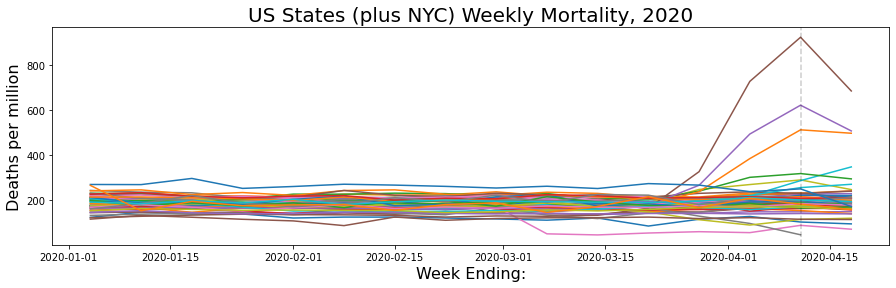

In [821]:
# Seems true of some places in particular

plt.figure(figsize=(15,4))
for state in test.index:
    plt.plot(test.loc[state])
plt.title('US States (plus NYC) Weekly Mortality, 2020', fontsize=20)
plt.ylabel('Deaths per million', fontsize=16)
plt.xlabel('Week Ending:', fontsize = 16)
plt.axvline(pd.to_datetime('2020-04-11'), color='k', linestyle='--', alpha=0.2);

In [395]:
# What states are the top ones in the graph above
test[test['2020-04-11'] > 300].loc[:, '2020-04-11']

region_code
MI     318.318
NJ     511.923
NY     620.915
NYC    921.685
Name: 2020-04-11 00:00:00, dtype: float64

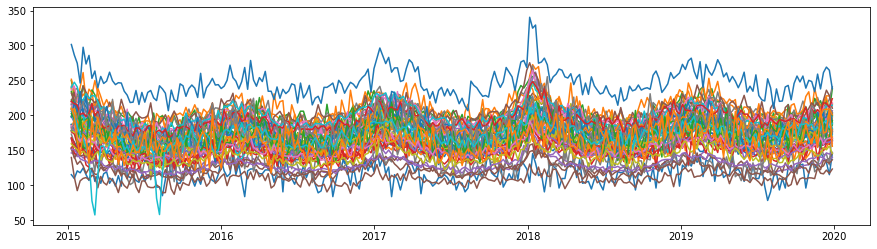

In [834]:
# All state data, pre-2020

plt.figure(figsize=(15,4))
for state in train.index:
    plt.plot(train.loc[state])

In [144]:
# Stationary
interpret_dftest(adfuller(us_train['deaths_per_mil']))

Test Statistic   -4.728621
p-value           0.000074
dtype: float64

### ACF/PACF plots

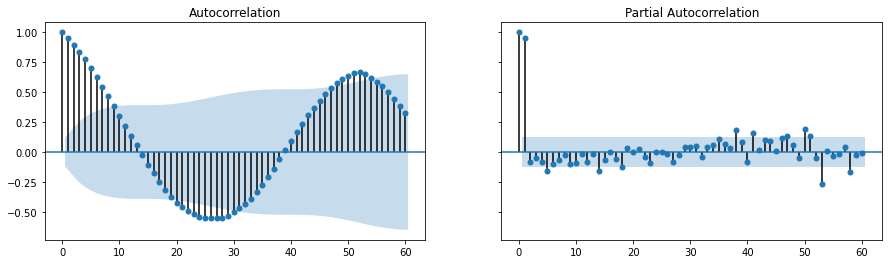

In [336]:
# Seasonal
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,4))
plot_acf(us_train['deaths_per_mil'], lags = 60, ax=ax1)
plot_pacf(us_train['deaths_per_mil'], lags = 60, ax=ax2);

# Split and Gridsearch

In [231]:
y_train, y_test = train_test_split(us_train['deaths_per_mil'],
                                  test_size = 0.1,
                                  shuffle = False)

In [266]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_d = 0
best_q = 0
best_P = 0
best_D = 0
best_Q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(4):
    for q in range(4):
        for d in range(2):
            for P in range(4):
                for D in range(2):
                    for Q in range(4):
                        # Insert try and except statements.
                        try:

                            # Fitting an SARIMA(p, 1, q) model.
                            print(f'Attempting to fit SARIMA(({p}, {d}, {q}) by ({P}, {D}, {Q}, 52)) model.')

                            my_order = (p,d,q)
                            my_seasonal_order = (P,D,Q,52)
                            model = SARIMAX(y_train, order=my_order, seasonal_order=my_seasonal_order)
                            
                            # Fit ARIMA model.
                            sarima = model.fit()

                            # Print out AIC for ARIMA(p, 1, q) model.
                            print(f'The AIC for this model is: {sarima.aic}')

                            # Is my current model's AIC better than our best_aic?
                            if sarima.aic < best_aic:

                                # If so, let's overwrite best_aic, best_p, and best_q.
                                best_aic = sarima.aic
                                best_p = p
                                best_q = q
                                best_d = d
                                best_P = P
                                best_D = D
                                best_Q = Q

                        except:
                            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the SARIMA(({best_p}, {best_d}, {best_q}) by ({best_P}, {best_D}, {best_Q}, 52)).')
print(f'This model has an AIC of {best_aic}.')

# Modified from code written by Matt Brems

Attempting to fit SARIMA((0, 0, 0) by (0, 0, 0, 52)) model.
The AIC for this model is: 3050.3731243444468
Attempting to fit SARIMA((0, 0, 0) by (0, 0, 1, 52)) model.
The AIC for this model is: 2859.06875256094
Attempting to fit SARIMA((0, 0, 0) by (0, 0, 2, 52)) model.
The AIC for this model is: 2706.236185550115
Attempting to fit SARIMA((0, 0, 0) by (0, 0, 3, 52)) model.
The AIC for this model is: 2582.8466483294105
Attempting to fit SARIMA((0, 0, 0) by (0, 1, 0, 52)) model.
The AIC for this model is: 1210.2788398020925
Attempting to fit SARIMA((0, 0, 0) by (0, 1, 1, 52)) model.
The AIC for this model is: 1198.8233760812527
Attempting to fit SARIMA((0, 0, 0) by (0, 1, 2, 52)) model.
The AIC for this model is: 1178.791664275157
Attempting to fit SARIMA((0, 0, 0) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1175.1082626947405
Attempting to fit SARIMA((0, 0, 0) by (1, 0, 0, 52)) model.
The AIC for this model is: 1888.7294446037827
Attempting to fit SARIMA((0, 0, 0) by (1, 0, 1, 52)) model.
The AIC for this model is: 1877.6770050567434
Attempting to fit SARIMA((0, 0, 0) by (1, 0, 2, 52)) model.
The AIC for this model is: 1863.5044990689871
Attempting to fit SARIMA((0, 0, 0) by (1, 0, 3, 52)) model.
The AIC for this model is: 1854.1513981323926
Attempting to fit SARIMA((0, 0, 0) by (1, 1, 0, 52)) model.
The AIC for this model is: 1206.1644729493053
Attempting to fit SARIMA((0, 0, 0) by (1, 1, 1, 52)) model.
The AIC for this model is: 1196.699280879963
Attempting to fit SARIMA((0, 0, 0) by (1, 1, 2, 52)) model.
The AIC for this model is: 1177.5402589349633
Attempting to fit SARIMA((0, 0, 0) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1175.077260977699
Attempting to fit SARIMA((0, 0, 0) by (2, 0, 0, 52)) model.
The AIC for this model is: 1884.8804366149502
Attempting to fit SARIMA((0, 0, 0) by (2, 0, 1, 52)) model.
The AIC for this model is: 1885.0259436705446
Attempting to fit SARIMA((0, 0, 0) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1879.6634666121736
Attempting to fit SARIMA((0, 0, 0) by (2, 0, 3, 52)) model.
The AIC for this model is: 1865.6604125782262
Attempting to fit SARIMA((0, 0, 0) by (2, 1, 0, 52)) model.
The AIC for this model is: 1173.961277118627
Attempting to fit SARIMA((0, 0, 0) by (2, 1, 1, 52)) model.
The AIC for this model is: 1170.693712314908
Attempting to fit SARIMA((0, 0, 0) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1171.5995811098444
Attempting to fit SARIMA((0, 0, 0) by (2, 1, 3, 52)) model.
The AIC for this model is: 1173.4638196311566
Attempting to fit SARIMA((0, 0, 0) by (3, 0, 0, 52)) model.
The AIC for this model is: 1853.905854733413
Attempting to fit SARIMA((0, 0, 0) by (3, 0, 1, 52)) model.
The AIC for this model is: 1849.9346705852072
Attempting to fit SARIMA((0, 0, 0) by (3, 0, 2, 52)) model.
The AIC for this model is: 1850.5980167567664
Attempting to fit SARIMA((0, 0, 0) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1886.5043421456407
Attempting to fit SARIMA((0, 0, 0) by (3, 1, 0, 52)) model.
The AIC for this model is: 1169.463273381944
Attempting to fit SARIMA((0, 0, 0) by (3, 1, 1, 52)) model.
The AIC for this model is: 1171.4642445378674
Attempting to fit SARIMA((0, 0, 0) by (3, 1, 2, 52)) model.
The AIC for this model is: 1173.463609380833
Attempting to fit SARIMA((0, 0, 0) by (3, 1, 3, 52)) model.
The AIC for this model is: 1175.4632979035616
Attempting to fit SARIMA((0, 1, 0) by (0, 0, 0, 52)) model.
The AIC for this model is: 1137.1682855023041
Attempting to fit SARIMA((0, 1, 0) by (0, 0, 1, 52)) model.
The AIC for this model is: 1110.3784117087055
Attempting to fit SARIMA((0, 1, 0) by (0, 0, 2, 52)) model.
The AIC for this model is: 1106.5766760603774
Attempting to fit SARIMA((0, 1, 0) by (0, 0, 3, 52)) model.
The AIC for this model is: 1077.4624043842605
Attempting to fit SARIMA((0, 1, 0) by (0, 1, 0, 52)) model.
The AIC for this model is: 916.2300910607296
Att

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1070.70657816951
Attempting to fit SARIMA((0, 1, 0) by (1, 1, 0, 52)) model.
The AIC for this model is: 876.0677512471673
Attempting to fit SARIMA((0, 1, 0) by (1, 1, 1, 52)) model.
The AIC for this model is: 846.985535695575
Attempting to fit SARIMA((0, 1, 0) by (1, 1, 2, 52)) model.
The AIC for this model is: 850.4005260958945
Attempting to fit SARIMA((0, 1, 0) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 840.4392909690955
Attempting to fit SARIMA((0, 1, 0) by (2, 0, 0, 52)) model.
The AIC for this model is: 1092.1542898602534
Attempting to fit SARIMA((0, 1, 0) by (2, 0, 1, 52)) model.
The AIC for this model is: 1076.99735778197
Attempting to fit SARIMA((0, 1, 0) by (2, 0, 2, 52)) model.
The AIC for this model is: 1079.496595802837
Attempting to fit SARIMA((0, 1, 0) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1071.5669411778529
Attempting to fit SARIMA((0, 1, 0) by (2, 1, 0, 52)) model.
The AIC for this model is: 838.8123656824907
Attempting to fit SARIMA((0, 1, 0) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 838.3339196471561
Attempting to fit SARIMA((0, 1, 0) by (2, 1, 2, 52)) model.
The AIC for this model is: 840.3285761036427
Attempting to fit SARIMA((0, 1, 0) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.3285607485063
Attempting to fit SARIMA((0, 1, 0) by (3, 0, 0, 52)) model.
The AIC for this model is: 1068.6334483548285
Attempting to fit SARIMA((0, 1, 0) by (3, 0, 1, 52)) model.
The AIC for this model is: 1069.517716721949
Attempting to fit SARIMA((0, 1, 0) by (3, 0, 2, 52)) model.
The AIC for this model is: 1071.5177112139588
Attempting to fit SARIMA((0, 1, 0) by (3, 0, 3, 52)) model.
The AIC for this model is: 1073.5177108926118
Attempting to fit SARIMA((0, 1, 0) by (3, 1, 0, 52)) model.
The AIC for this model is: 838.3286030944861
Attempting to fit SARIMA((0, 1, 0) by (3, 1, 1, 52)) model.
The AIC for this model is: 840.3286012789616
Attempting to fit SARIMA((0, 1, 0) by (3, 1, 2, 52)) model.
The AIC for this model is: 842.3285745808288
Attempting to fit SARIMA((0, 1, 0) by (3, 1, 3, 52)) model.
The AIC for this model is: 844.3285573312761
Attempting to fit SARIMA((0, 0, 1) by (0, 0, 0, 52)) model.
The AIC for this model is: 2735.195966962988
Attempt

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 2280.6094284790106
Attempting to fit SARIMA((0, 0, 1) by (0, 1, 0, 52)) model.
The AIC for this model is: 1074.8380198698987
Attempting to fit SARIMA((0, 0, 1) by (0, 1, 1, 52)) model.
The AIC for this model is: 1054.4524452131498
Attempting to fit SARIMA((0, 0, 1) by (0, 1, 2, 52)) model.
The AIC for this model is: 1047.6601104513188
Attempting to fit SARIMA((0, 0, 1) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1039.1153720365878
Attempting to fit SARIMA((0, 0, 1) by (1, 0, 0, 52)) model.
The AIC for this model is: 1780.614772961703
Attempting to fit SARIMA((0, 0, 1) by (1, 0, 1, 52)) model.
The AIC for this model is: 1774.7869025798213
Attempting to fit SARIMA((0, 0, 1) by (1, 0, 2, 52)) model.
The AIC for this model is: 2548.168376477175
Attempting to fit SARIMA((0, 0, 1) by (1, 0, 3, 52)) model.
The AIC for this model is: 2398.2902070555633
Attempting to fit SARIMA((0, 0, 1) by (1, 1, 0, 52)) model.
The AIC for this model is: 1065.200281568648
Attempting to fit SARIMA((0, 0, 1) by (1, 1, 1, 52)) model.
The AIC for this model is: 1053.381131259454
Attempting to fit SARIMA((0, 0, 1) by (1, 1, 2, 52)) model.
The AIC for this model is: 1042.9920014324753
Attempting to fit SARIMA((0, 0, 1) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1041.0237048139488
Attempting to fit SARIMA((0, 0, 1) by (2, 0, 0, 52)) model.
The AIC for this model is: 1776.5864566858013
Attempting to fit SARIMA((0, 0, 1) by (2, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1788.6438399597512
Attempting to fit SARIMA((0, 0, 1) by (2, 0, 2, 52)) model.
The AIC for this model is: 1778.4693122391373
Attempting to fit SARIMA((0, 0, 1) by (2, 0, 3, 52)) model.
The AIC for this model is: 1782.9387334261478
Attempting to fit SARIMA((0, 0, 1) by (2, 1, 0, 52)) model.
The AIC for this model is: 1039.6036571856312
Attempting to fit SARIMA((0, 0, 1) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1038.4427211500833
Attempting to fit SARIMA((0, 0, 1) by (2, 1, 2, 52)) model.
The AIC for this model is: 1039.9899920560292
Attempting to fit SARIMA((0, 0, 1) by (2, 1, 3, 52)) model.
The AIC for this model is: 1041.9855311148558
Attempting to fit SARIMA((0, 0, 1) by (3, 0, 0, 52)) model.
The AIC for this model is: 1773.3672305604716
Attempting to fit SARIMA((0, 0, 1) by (3, 0, 1, 52)) model.
The AIC for this model is: 1786.6193779897835
Attempting to fit SARIMA((0, 0, 1) by (3, 0, 2, 52)) model.
The AIC for this model is: 1806.0888064230667
Attempting to fit SARIMA((0, 0, 1) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1778.616967934237
Attempting to fit SARIMA((0, 0, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 1037.986221348203
Attempting to fit SARIMA((0, 0, 1) by (3, 1, 1, 52)) model.
The AIC for this model is: 1039.9860603837903
Attempting to fit SARIMA((0, 0, 1) by (3, 1, 2, 52)) model.
The AIC for this model is: 1041.9862362799145
Attempting to fit SARIMA((0, 0, 1) by (3, 1, 3, 52)) model.
The AIC for this model is: 1043.9865890699382
Attempting to fit SARIMA((0, 1, 1) by (0, 0, 0, 52)) model.
The AIC for this model is: 1134.9297497567536
Attempting to fit SARIMA((0, 1, 1) by (0, 0, 1, 52)) model.
The AIC for this model is: 1111.7157581679767
Attempting to fit SARIMA((0, 1, 1) by (0, 0, 2, 52)) model.
The AIC for this model is: 1107.8589109043555
Attempting to fit SARIMA((0, 1, 1) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1079.3459825438867
Attempting to fit SARIMA((0, 1, 1) by (0, 1, 0, 52)) model.
The AIC for this model is: 917.9611874444879
Attempting to fit SARIMA((0, 1, 1) by (0, 1, 1, 52)) model.
The AIC for this model is: 848.579173594343
Attempting to fit SARIMA((0, 1, 1) by (0, 1, 2, 52)) model.
The AIC for this model is: 846.8013518095881
Attempting to fit SARIMA((0, 1, 1) by (0, 1, 3, 52)) model.
The AIC for this model is: 840.9480974875779
Attempting to fit SARIMA((0, 1, 1) by (1, 0, 0, 52)) model.
The AIC for this model is: 1102.7757920397653
Attempting to fit SARIMA((0, 1, 1) by (1, 0, 1, 52)) model.
The AIC for this model is: 1078.4169439824022
Attempting to fit SARIMA((0, 1, 1) by (1, 0, 2, 52)) model.
The AIC for this model is: 1078.0782607390197
Attempting to fit SARIMA((0, 1, 1) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1072.7066457361384
Attempting to fit SARIMA((0, 1, 1) by (1, 1, 0, 52)) model.
The AIC for this model is: 877.9564790626973
Attempting to fit SARIMA((0, 1, 1) by (1, 1, 1, 52)) model.
The AIC for this model is: 848.2911439536601
Attempting to fit SARIMA((0, 1, 1) by (1, 1, 2, 52)) model.
The AIC for this model is: 851.6847613108195
Attempting to fit SARIMA((0, 1, 1) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 840.1928576449822
Attempting to fit SARIMA((0, 1, 1) by (2, 0, 0, 52)) model.
The AIC for this model is: 1093.9277356813232
Attempting to fit SARIMA((0, 1, 1) by (2, 0, 1, 52)) model.
The AIC for this model is: 1078.9129026954333
Attempting to fit SARIMA((0, 1, 1) by (2, 0, 2, 52)) model.
The AIC for this model is: 1081.481373371903
Attempting to fit SARIMA((0, 1, 1) by (2, 0, 3, 52)) model.
The AIC for this model is: 1073.5292899859962
Attempting to fit SARIMA((0, 1, 1) by (2, 1, 0, 52)) model.
The AIC for this model is: 838.1059947296633
Attempting to fit SARIMA((0, 1, 1) by (2, 1, 1, 52)) model.
The AIC for this model is: 838.1032952448732
Attempting to fit SARIMA((0, 1, 1) by (2, 1, 2, 52)) model.
The AIC for this model is: 840.1032972175501
Attempting to fit SARIMA((0, 1, 1) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.1468566306055
Attempting to fit SARIMA((0, 1, 1) by (3, 0, 0, 52)) model.
The AIC for this model is: 1070.5838725918911
Attempting to fit SARIMA((0, 1, 1) by (3, 0, 1, 52)) model.
The AIC for this model is: 1071.4900036815334
Attempting to fit SARIMA((0, 1, 1) by (3, 0, 2, 52)) model.
The AIC for this model is: 1073.490002639803
Attempting to fit SARIMA((0, 1, 1) by (3, 0, 3, 52)) model.
The AIC for this model is: 1075.4900050003469
Attempting to fit SARIMA((0, 1, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 838.1033189089521
Attempting to fit SARIMA((0, 1, 1) by (3, 1, 1, 52)) model.
The AIC for this model is: 840.1033205346861
Attempting to fit SARIMA((0, 1, 1) by (3, 1, 2, 52)) model.
The AIC for this model is: 842.1032912743336
Attempting to fit SARIMA((0, 1, 1) by (3, 1, 3, 52)) model.
The AIC for this model is: 844.1032725794191
Attempting to fit SARIMA((0, 0, 2) by (0, 0, 0, 52)) model.
The AIC for this model is: 2573.096038215338
Attempt

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 2286.741521848816
Attempting to fit SARIMA((0, 0, 2) by (0, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 2199.9484521722975
Attempting to fit SARIMA((0, 0, 2) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 2163.615406214638
Attempting to fit SARIMA((0, 0, 2) by (0, 1, 0, 52)) model.
The AIC for this model is: 1082.269330628228
Attempting to fit SARIMA((0, 0, 2) by (0, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 968.4163995021447
Attempting to fit SARIMA((0, 0, 2) by (0, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 967.6625776904727
Attempting to fit SARIMA((0, 0, 2) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1060.38084086266
Attempting to fit SARIMA((0, 0, 2) by (1, 0, 0, 52)) model.
The AIC for this model is: 1912.1781307080082
Attempting to fit SARIMA((0, 0, 2) by (1, 0, 1, 52)) model.
The AIC for this model is: 2327.9621257873287
Attempting to fit SARIMA((0, 0, 2) by (1, 0, 2, 52)) model.
The AIC for this model is: 2290.7684140368497
Attempting to fit SARIMA((0, 0, 2) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 2175.757539171481
Attempting to fit SARIMA((0, 0, 2) by (1, 1, 0, 52)) model.
The AIC for this model is: 980.1325145943035
Attempting to fit SARIMA((0, 0, 2) by (1, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.141531115775
Attempting to fit SARIMA((0, 0, 2) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 978.0855027240372
Attempting to fit SARIMA((0, 0, 2) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1061.0276746930926
Attempting to fit SARIMA((0, 0, 2) by (2, 0, 0, 52)) model.
Attempting to fit SARIMA((0, 0, 2) by (2, 0, 1, 52)) model.
The AIC for this model is: 1784.7277192420513
Attempting to fit SARIMA((0, 0, 2) by (2, 0, 2, 52)) model.
The AIC for this model is: 2436.992662950887
Attempting to fit SARIMA((0, 0, 2) by (2, 0, 3, 52)) model.
Attempting to fit SARIMA((0, 0, 2) by (2, 1, 0, 52)) model.
The AIC for this model is: 1022.829027708841
Attempting to fit SARIMA((0, 0, 2) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1057.0390560986857
Attempting to fit SARIMA((0, 0, 2) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1058.602872555803
Attempting to fit SARIMA((0, 0, 2) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1060.4585493156355
Attempting to fit SARIMA((0, 0, 2) by (3, 0, 0, 52)) model.
Attempting to fit SARIMA((0, 0, 2) by (3, 0, 1, 52)) model.
The AIC for this model is: 1861.6642038060086
Attempting to fit SARIMA((0, 0, 2) by (3, 0, 2, 52)) model.
Attempting to fit SARIMA((0, 0, 2) by (3, 0, 3, 52)) model.
Attempting to fit SARIMA((0, 0, 2) by (3, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1056.4639685978605
Attempting to fit SARIMA((0, 0, 2) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 964.6069904947954
Attempting to fit SARIMA((0, 0, 2) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1060.4514252089261
Attempting to fit SARIMA((0, 0, 2) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 968.8708953692787
Attempting to fit SARIMA((0, 1, 2) by (0, 0, 0, 52)) model.
The AIC for this model is: 1131.202852995118
Attempting to fit SARIMA((0, 1, 2) by (0, 0, 1, 52)) model.
The AIC for this model is: 1106.5834541168538
Attempting to fit SARIMA((0, 1, 2) by (0, 0, 2, 52)) model.
The AIC for this model is: 1102.552757363046
Attempting to fit SARIMA((0, 1, 2) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.6359762363863
Attempting to fit SARIMA((0, 1, 2) by (0, 1, 0, 52)) model.
The AIC for this model is: 912.3621276324113
Attempting to fit SARIMA((0, 1, 2) by (0, 1, 1, 52)) model.
The AIC for this model is: 846.4748039565579
Attempting to fit SARIMA((0, 1, 2) by (0, 1, 2, 52)) model.
The AIC for this model is: 846.1418723470108
Attempting to fit SARIMA((0, 1, 2) by (0, 1, 3, 52)) model.
The AIC for this model is: 840.3231224333421
Attempting to fit SARIMA((0, 1, 2) by (1, 0, 0, 52)) model.
The AIC for this model is: 1097.1615835713935
Attempting to fit SARIMA((0, 1, 2) by (1, 0, 1, 52)) model.
The AIC for this model is: 1074.6869643367354
Attempting to fit SARIMA((0, 1, 2) by (1, 0, 2, 52)) model.
The AIC for this model is: 1075.3957991672721
Attempting to fit SARIMA((0, 1, 2) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1070.43902739815
Attempting to fit SARIMA((0, 1, 2) by (1, 1, 0, 52)) model.
The AIC for this model is: 874.3299616097949
Attempting to fit SARIMA((0, 1, 2) by (1, 1, 1, 52)) model.
The AIC for this model is: 847.0312543070797
Attempting to fit SARIMA((0, 1, 2) by (1, 1, 2, 52)) model.
The AIC for this model is: 849.4989734996311
Attempting to fit SARIMA((0, 1, 2) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 840.6636101707434
Attempting to fit SARIMA((0, 1, 2) by (2, 0, 0, 52)) model.
The AIC for this model is: 1089.074318972307
Attempting to fit SARIMA((0, 1, 2) by (2, 0, 1, 52)) model.
The AIC for this model is: 1075.80489251571
Attempting to fit SARIMA((0, 1, 2) by (2, 0, 2, 52)) model.
The AIC for this model is: 1077.6518863518872
Attempting to fit SARIMA((0, 1, 2) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1072.0609107012228
Attempting to fit SARIMA((0, 1, 2) by (2, 1, 0, 52)) model.
The AIC for this model is: 838.7266964762952
Attempting to fit SARIMA((0, 1, 2) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 838.5088759983041
Attempting to fit SARIMA((0, 1, 2) by (2, 1, 2, 52)) model.
The AIC for this model is: 840.5084263960291
Attempting to fit SARIMA((0, 1, 2) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.5660700634212
Attempting to fit SARIMA((0, 1, 2) by (3, 0, 0, 52)) model.
The AIC for this model is: 1069.1771129462004
Attempting to fit SARIMA((0, 1, 2) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1069.8866922700113
Attempting to fit SARIMA((0, 1, 2) by (3, 0, 2, 52)) model.
The AIC for this model is: 1071.8823742587201
Attempting to fit SARIMA((0, 1, 2) by (3, 0, 3, 52)) model.
The AIC for this model is: 1073.8823740765756
Attempting to fit SARIMA((0, 1, 2) by (3, 1, 0, 52)) model.
The AIC for this model is: 838.5084531757975
Attempting to fit SARIMA((0, 1, 2) by (3, 1, 1, 52)) model.
The AIC for this model is: 840.508455283155
Attempting to fit SARIMA((0, 1, 2) by (3, 1, 2, 52)) model.
The AIC for this model is: 842.5084228121204
Attempting to fit SARIMA((0, 1, 2) by (3, 1, 3, 52)) model.
The AIC for this model is: 844.5084051663814
Attempting to fit SARIMA((0, 0, 3) by (0, 0, 0, 52)) model.
The AIC for this model is: 2214.267774871051
Attempting to fit SARIMA((0, 0, 3) by (0, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 2063.3015745857547
Attempting to fit SARIMA((0, 0, 3) by (0, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1981.4414134496405
Attempting to fit SARIMA((0, 0, 3) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1897.6840915482137
Attempting to fit SARIMA((0, 0, 3) by (0, 1, 0, 52)) model.
The AIC for this model is: 952.0126885758447
Attempting to fit SARIMA((0, 0, 3) by (0, 1, 1, 52)) model.
The AIC for this model is: 919.512095580284
Attempting to fit SARIMA((0, 0, 3) by (0, 1, 2, 52)) model.
The AIC for this model is: 918.7988741102313
Attempting to fit SARIMA((0, 0, 3) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 914.7196702955338
Attempting to fit SARIMA((0, 0, 3) by (1, 0, 0, 52)) model.
The AIC for this model is: 1567.2038417126025
Attempting to fit SARIMA((0, 0, 3) by (1, 0, 1, 52)) model.
The AIC for this model is: 1575.050453916806
Attempting to fit SARIMA((0, 0, 3) by (1, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 2068.292462320827
Attempting to fit SARIMA((0, 0, 3) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 2411.137876410534
Attempting to fit SARIMA((0, 0, 3) by (1, 1, 0, 52)) model.
The AIC for this model is: 933.7569845659558
Attempting to fit SARIMA((0, 0, 3) by (1, 1, 1, 52)) model.
The AIC for this model is: 919.8430734985432
Attempting to fit SARIMA((0, 0, 3) by (1, 1, 2, 52)) model.
The AIC for this model is: 916.1696603734381
Attempting to fit SARIMA((0, 0, 3) by (1, 1, 3, 52)) model.
The AIC for this model is: 916.5177922680982
Attempting to fit SARIMA((0, 0, 3) by (2, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1561.1281689701661
Attempting to fit SARIMA((0, 0, 3) by (2, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1575.0204910717703
Attempting to fit SARIMA((0, 0, 3) by (2, 0, 2, 52)) model.
Attempting to fit SARIMA((0, 0, 3) by (2, 0, 3, 52)) model.
Attempting to fit SARIMA((0, 0, 3) by (2, 1, 0, 52)) model.
The AIC for this model is: 913.1099715224445
Attempting to fit SARIMA((0, 0, 3) by (2, 1, 1, 52)) model.
The AIC for this model is: 914.5227257116105
Attempting to fit SARIMA((0, 0, 3) by (2, 1, 2, 52)) model.
The AIC for this model is: 916.5206523749343
Attempting to fit SARIMA((0, 0, 3) by (2, 1, 3, 52)) model.
The AIC for this model is: 918.5176613010268
Attempting to fit SARIMA((0, 0, 3) by (3, 0, 0, 52)) model.
The AIC for this model is: 2379.0307293854794
Attempting to fit SARIMA((0, 0, 3) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1557.3747748679057
Attempting to fit SARIMA((0, 0, 3) by (3, 0, 2, 52)) model.
The AIC for this model is: 1911.7034813760465
Attempting to fit SARIMA((0, 0, 3) by (3, 0, 3, 52)) model.
The AIC for this model is: 2544.3761650966217
Attempting to fit SARIMA((0, 0, 3) by (3, 1, 0, 52)) model.
The AIC for this model is: 914.5202195599404
Attempting to fit SARIMA((0, 0, 3) by (3, 1, 1, 52)) model.
The AIC for this model is: 916.5194336169989
Attempting to fit SARIMA((0, 0, 3) by (3, 1, 2, 52)) model.
The AIC for this model is: 918.5179930004407
Attempting to fit SARIMA((0, 0, 3) by (3, 1, 3, 52)) model.
The AIC for this model is: 920.5186476151475
Attempting to fit SARIMA((0, 1, 3) by (0, 0, 0, 52)) model.
The AIC for this model is: 1133.1831141109678
Attempting to fit SARIMA((0, 1, 3) by (0, 0, 1, 52)) model.
The AIC for this model is: 1108.5485198033853
Attempting to fit SARIMA((0, 1, 3) by (0, 0, 2, 52)) model.
The AIC for this model is: 1104.5507094920642
Atte

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1078.623536506963
Attempting to fit SARIMA((0, 1, 3) by (0, 1, 0, 52)) model.
The AIC for this model is: 914.2785113684645
Attempting to fit SARIMA((0, 1, 3) by (0, 1, 1, 52)) model.
The AIC for this model is: 848.1360123218533
Attempting to fit SARIMA((0, 1, 3) by (0, 1, 2, 52)) model.
The AIC for this model is: 847.6785732576718
Attempting to fit SARIMA((0, 1, 3) by (0, 1, 3, 52)) model.
The AIC for this model is: 841.9119173417683
Attempting to fit SARIMA((0, 1, 3) by (1, 0, 0, 52)) model.
The AIC for this model is: 1099.1614211591052
Attempting to fit SARIMA((0, 1, 3) by (1, 0, 1, 52)) model.
The AIC for this model is: 1076.6280282620987
Attempting to fit SARIMA((0, 1, 3) by (1, 0, 2, 52)) model.
The AIC for this model is: 1077.2808453475468
Attempting to fit SARIMA((0, 1, 3) by (1, 0, 3, 52)) model.
The AIC for this model is: 1072.3994953118554
Attempting to fit SARIMA((0, 1, 3) by (1, 1, 0, 52)) model.
The AIC for this model is: 875.9457538795382
Attemp

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.093312246601
Attempting to fit SARIMA((0, 1, 3) by (2, 0, 0, 52)) model.
The AIC for this model is: 1091.017928425319
Attempting to fit SARIMA((0, 1, 3) by (2, 0, 1, 52)) model.
The AIC for this model is: 1077.7273818398621
Attempting to fit SARIMA((0, 1, 3) by (2, 0, 2, 52)) model.
The AIC for this model is: 1079.616013207601
Attempting to fit SARIMA((0, 1, 3) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1073.9046194162943
Attempting to fit SARIMA((0, 1, 3) by (2, 1, 0, 52)) model.
The AIC for this model is: 840.0599162648289
Attempting to fit SARIMA((0, 1, 3) by (2, 1, 1, 52)) model.
The AIC for this model is: 839.9796927136025
Attempting to fit SARIMA((0, 1, 3) by (2, 1, 2, 52)) model.
The AIC for this model is: 841.9796971298856
Attempting to fit SARIMA((0, 1, 3) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.0723608610851
Attempting to fit SARIMA((0, 1, 3) by (3, 0, 0, 52)) model.
The AIC for this model is: 1071.1235099823084
Attempting to fit SARIMA((0, 1, 3) by (3, 0, 1, 52)) model.
The AIC for this model is: 1071.8493216817374
Attempting to fit SARIMA((0, 1, 3) by (3, 0, 2, 52)) model.
The AIC for this model is: 1073.8452954648064
Attempting to fit SARIMA((0, 1, 3) by (3, 0, 3, 52)) model.
The AIC for this model is: 1075.8452964464225
Attempting to fit SARIMA((0, 1, 3) by (3, 1, 0, 52)) model.
The AIC for this model is: 839.979722364233
Attempting to fit SARIMA((0, 1, 3) by (3, 1, 1, 52)) model.
The AIC for this model is: 841.9797247107999
Attempting to fit SARIMA((0, 1, 3) by (3, 1, 2, 52)) model.
The AIC for this model is: 843.979693205098
Attempting to fit SARIMA((0, 1, 3) by (3, 1, 3, 52)) model.
The AIC for this model is: 845.9796744216069
Attempting to fit SARIMA((1, 0, 0) by (0, 0, 0, 52)) model.
The AIC for this model is: 1152.309298637768
Attempti

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1084.417358408234
Attempting to fit SARIMA((1, 0, 0) by (1, 1, 0, 52)) model.
The AIC for this model is: 878.3555435796266
Attempting to fit SARIMA((1, 0, 0) by (1, 1, 1, 52)) model.
The AIC for this model is: 849.3963073937679
Attempting to fit SARIMA((1, 0, 0) by (1, 1, 2, 52)) model.
The AIC for this model is: 852.1674328496823
Attempting to fit SARIMA((1, 0, 0) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.7942384992916
Attempting to fit SARIMA((1, 0, 0) by (2, 0, 0, 52)) model.
The AIC for this model is: 1107.3188115748148
Attempting to fit SARIMA((1, 0, 0) by (2, 0, 1, 52)) model.
The AIC for this model is: 1090.661904210316
Attempting to fit SARIMA((1, 0, 0) by (2, 0, 2, 52)) model.
The AIC for this model is: 1093.2195894824972
Attempting to fit SARIMA((1, 0, 0) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1084.041504385636
Attempting to fit SARIMA((1, 0, 0) by (2, 1, 0, 52)) model.
The AIC for this model is: 841.4104102515626
Attempting to fit SARIMA((1, 0, 0) by (2, 1, 1, 52)) model.
The AIC for this model is: 841.7457315866544
Attempting to fit SARIMA((1, 0, 0) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.6716739738664
Attempting to fit SARIMA((1, 0, 0) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.7956569879216
Attempting to fit SARIMA((1, 0, 0) by (3, 0, 0, 52)) model.
The AIC for this model is: 1082.981725936695
Attempting to fit SARIMA((1, 0, 0) by (3, 0, 1, 52)) model.
The AIC for this model is: 1082.3327737672744
Attempting to fit SARIMA((1, 0, 0) by (3, 0, 2, 52)) model.
The AIC for this model is: 1084.6096974693592
Attempting to fit SARIMA((1, 0, 0) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1086.8351786986177
Attempting to fit SARIMA((1, 0, 0) by (3, 1, 0, 52)) model.
The AIC for this model is: 841.6817904081577
Attempting to fit SARIMA((1, 0, 0) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.6456587431562
Attempting to fit SARIMA((1, 0, 0) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.6783033696443
Attempting to fit SARIMA((1, 0, 0) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.7016770297583
Attempting to fit SARIMA((1, 1, 0) by (0, 0, 0, 52)) model.
The AIC for this model is: 1133.5403817581177
Attempting to fit SARIMA((1, 1, 0) by (0, 0, 1, 52)) model.
The AIC for this model is: 1111.457458696159
Attempting to fit SARIMA((1, 1, 0) by (0, 0, 2, 52)) model.
The AIC for this model is: 1107.5815324090356
Attempting to fit SARIMA((1, 1, 0) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1079.309660019344
Attempting to fit SARIMA((1, 1, 0) by (0, 1, 0, 52)) model.
The AIC for this model is: 917.8636984929607
Attempting to fit SARIMA((1, 1, 0) by (0, 1, 1, 52)) model.
The AIC for this model is: 848.4151285904952
Attempting to fit SARIMA((1, 1, 0) by (0, 1, 2, 52)) model.
The AIC for this model is: 846.5898120322857
Attempting to fit SARIMA((1, 1, 0) by (0, 1, 3, 52)) model.
The AIC for this model is: 840.6362844339446
Attempting to fit SARIMA((1, 1, 0) by (1, 0, 0, 52)) model.
The AIC for this model is: 1102.6884676296258
Attempting to fit SARIMA((1, 1, 0) by (1, 0, 1, 52)) model.
The AIC for this model is: 1078.404132238542
Attempting to fit SARIMA((1, 1, 0) by (1, 0, 2, 52)) model.
The AIC for this model is: 1078.0635252085326
Attempting to fit SARIMA((1, 1, 0) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1072.7066926609618
Attempting to fit SARIMA((1, 1, 0) by (1, 1, 0, 52)) model.
The AIC for this model is: 877.9182306320002
Attempting to fit SARIMA((1, 1, 0) by (1, 1, 1, 52)) model.
The AIC for this model is: 848.1070606728833
Attempting to fit SARIMA((1, 1, 0) by (1, 1, 2, 52)) model.
The AIC for this model is: 851.4723773206855
Attempting to fit SARIMA((1, 1, 0) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 839.7714187335433
Attempting to fit SARIMA((1, 1, 0) by (2, 0, 0, 52)) model.
The AIC for this model is: 1093.8443594175951
Attempting to fit SARIMA((1, 1, 0) by (2, 0, 1, 52)) model.
The AIC for this model is: 1078.9210670290777
Attempting to fit SARIMA((1, 1, 0) by (2, 0, 2, 52)) model.
The AIC for this model is: 1081.503149504064
Attempting to fit SARIMA((1, 1, 0) by (2, 0, 3, 52)) model.
The AIC for this model is: 1073.5197419788544
Attempting to fit SARIMA((1, 1, 0) by (2, 1, 0, 52)) model.
The AIC for this model is: 837.6329368744586
Attempting to fit SARIMA((1, 1, 0) by (2, 1, 1, 52)) model.
The AIC for this model is: 837.685034953694
Attempting to fit SARIMA((1, 1, 0) by (2, 1, 2, 52)) model.
The AIC for this model is: 839.685035917625
Attempting to fit SARIMA((1, 1, 0) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 841.7381225058646
Attempting to fit SARIMA((1, 1, 0) by (3, 0, 0, 52)) model.
The AIC for this model is: 1070.5699823037257
Attempting to fit SARIMA((1, 1, 0) by (3, 0, 1, 52)) model.
The AIC for this model is: 1071.4820822666215
Attempting to fit SARIMA((1, 1, 0) by (3, 0, 2, 52)) model.
The AIC for this model is: 1073.4820782070456
Attempting to fit SARIMA((1, 1, 0) by (3, 0, 3, 52)) model.
The AIC for this model is: 1075.4820779958848
Attempting to fit SARIMA((1, 1, 0) by (3, 1, 0, 52)) model.
The AIC for this model is: 837.6850589435386
Attempting to fit SARIMA((1, 1, 0) by (3, 1, 1, 52)) model.
The AIC for this model is: 839.6850610623791
Attempting to fit SARIMA((1, 1, 0) by (3, 1, 2, 52)) model.
The AIC for this model is: 841.6850308594773
Attempting to fit SARIMA((1, 1, 0) by (3, 1, 3, 52)) model.
The AIC for this model is: 843.6850114624559
Attempting to fit SARIMA((1, 0, 1) by (0, 0, 0, 52)) model.
The AIC for this model is: 1150.0676062442108
Attem

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1094.5504380227965
Attempting to fit SARIMA((1, 0, 1) by (0, 1, 0, 52)) model.
The AIC for this model is: 919.9724873326338
Attempting to fit SARIMA((1, 0, 1) by (0, 1, 1, 52)) model.
The AIC for this model is: 851.0679257050017
Attempting to fit SARIMA((1, 0, 1) by (0, 1, 2, 52)) model.
The AIC for this model is: 850.066692674985
Attempting to fit SARIMA((1, 0, 1) by (0, 1, 3, 52)) model.
The AIC for this model is: 844.4158993026111
Attempting to fit SARIMA((1, 0, 1) by (1, 0, 0, 52)) model.
The AIC for this model is: 1117.974269095955
Attempting to fit SARIMA((1, 0, 1) by (1, 0, 1, 52)) model.
The AIC for this model is: 1093.0128556092964
Attempting to fit SARIMA((1, 0, 1) by (1, 0, 2, 52)) model.
The AIC for this model is: 1092.2356279061828
Attempting to fit SARIMA((1, 0, 1) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1086.008748543074
Attempting to fit SARIMA((1, 0, 1) by (1, 1, 0, 52)) model.
The AIC for this model is: 880.3477009790804
Attempting to fit SARIMA((1, 0, 1) by (1, 1, 1, 52)) model.
The AIC for this model is: 851.1716993585799
Attempting to fit SARIMA((1, 0, 1) by (1, 1, 2, 52)) model.
The AIC for this model is: 853.9524361449704
Attempting to fit SARIMA((1, 0, 1) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.593192234634
Attempting to fit SARIMA((1, 0, 1) by (2, 0, 0, 52)) model.
The AIC for this model is: 1109.0874852736538
Attempting to fit SARIMA((1, 0, 1) by (2, 0, 1, 52)) model.
The AIC for this model is: 1093.2861552427883
Attempting to fit SARIMA((1, 0, 1) by (2, 0, 2, 52)) model.
The AIC for this model is: 1095.8610570371723
Attempting to fit SARIMA((1, 0, 1) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1086.5931583255087
Attempting to fit SARIMA((1, 0, 1) by (2, 1, 0, 52)) model.
The AIC for this model is: 841.9402425583753
Attempting to fit SARIMA((1, 0, 1) by (2, 1, 1, 52)) model.
The AIC for this model is: 842.498367505744
Attempting to fit SARIMA((1, 0, 1) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.3616624600327
Attempting to fit SARIMA((1, 0, 1) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 846.4530283233512
Attempting to fit SARIMA((1, 0, 1) by (3, 0, 0, 52)) model.
The AIC for this model is: 1084.924928569787
Attempting to fit SARIMA((1, 0, 1) by (3, 0, 1, 52)) model.
The AIC for this model is: 1085.2453839593331
Attempting to fit SARIMA((1, 0, 1) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1087.0329534436364
Attempting to fit SARIMA((1, 0, 1) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1089.3249094114076
Attempting to fit SARIMA((1, 0, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 842.4108339970853
Attempting to fit SARIMA((1, 0, 1) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.3603326542147
Attempting to fit SARIMA((1, 0, 1) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 846.3711977229119
Attempting to fit SARIMA((1, 0, 1) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 848.4615462344914
Attempting to fit SARIMA((1, 1, 1) by (0, 0, 0, 52)) model.
The AIC for this model is: 1126.3056608392785
Attempting to fit SARIMA((1, 1, 1) by (0, 0, 1, 52)) model.
The AIC for this model is: 1107.1647445404878
Attempting to fit SARIMA((1, 1, 1) by (0, 0, 2, 52)) model.
The AIC for this model is: 1103.6765943052658
Attempting to fit SARIMA((1, 1, 1) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1078.804223217474
Attempting to fit SARIMA((1, 1, 1) by (0, 1, 0, 52)) model.
The AIC for this model is: 918.1329715344175
Attempting to fit SARIMA((1, 1, 1) by (0, 1, 1, 52)) model.
The AIC for this model is: 848.3578702146917
Attempting to fit SARIMA((1, 1, 1) by (0, 1, 2, 52)) model.
The AIC for this model is: 846.653431993997
Attempting to fit SARIMA((1, 1, 1) by (0, 1, 3, 52)) model.
The AIC for this model is: 840.8639468103324
Attempting to fit SARIMA((1, 1, 1) by (1, 0, 0, 52)) model.
The AIC for this model is: 1100.19789321628
Attempting to fit SARIMA((1, 1, 1) by (1, 0, 1, 52)) model.
The AIC for this model is: 1078.3203850034704
Attempting to fit SARIMA((1, 1, 1) by (1, 0, 2, 52)) model.
The AIC for this model is: 1078.2859255101048
Attempting to fit SARIMA((1, 1, 1) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1073.5076932805252
Attempting to fit SARIMA((1, 1, 1) by (1, 1, 0, 52)) model.
The AIC for this model is: 877.7746817597096
Attempting to fit SARIMA((1, 1, 1) by (1, 1, 1, 52)) model.
The AIC for this model is: 848.0763629277058
Attempting to fit SARIMA((1, 1, 1) by (1, 1, 2, 52)) model.
The AIC for this model is: 851.4484921965794
Attempting to fit SARIMA((1, 1, 1) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 840.4391415951318
Attempting to fit SARIMA((1, 1, 1) by (2, 0, 0, 52)) model.
The AIC for this model is: 1092.4345227379758
Attempting to fit SARIMA((1, 1, 1) by (2, 0, 1, 52)) model.
The AIC for this model is: 1078.9539432161357
Attempting to fit SARIMA((1, 1, 1) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1081.5514480544568
Attempting to fit SARIMA((1, 1, 1) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1074.8702075537005
Attempting to fit SARIMA((1, 1, 1) by (2, 1, 0, 52)) model.
The AIC for this model is: 838.3254870279895
Attempting to fit SARIMA((1, 1, 1) by (2, 1, 1, 52)) model.
The AIC for this model is: 838.355876210941
Attempting to fit SARIMA((1, 1, 1) by (2, 1, 2, 52)) model.
The AIC for this model is: 840.355878568337
Attempting to fit SARIMA((1, 1, 1) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.4184623457757
Attempting to fit SARIMA((1, 1, 1) by (3, 0, 0, 52)) model.
The AIC for this model is: 1071.945336040511
Attempting to fit SARIMA((1, 1, 1) by (3, 0, 1, 52)) model.
The AIC for this model is: 1072.739520393912
Attempting to fit SARIMA((1, 1, 1) by (3, 0, 2, 52)) model.
The AIC for this model is: 1074.7391284673304
Attempting to fit SARIMA((1, 1, 1) by (3, 0, 3, 52)) model.
The AIC for this model is: 1076.7391289436518
Attempting to fit SARIMA((1, 1, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 838.3559021041551
Attempting to fit SARIMA((1, 1, 1) by (3, 1, 1, 52)) model.
The AIC for this model is: 840.3559024794656
Attempting to fit SARIMA((1, 1, 1) by (3, 1, 2, 52)) model.
The AIC for this model is: 842.3558720468438
Attempting to fit SARIMA((1, 1, 1) by (3, 1, 3, 52)) model.
The AIC for this model is: 844.3558534792569
Attempting to fit SARIMA((1, 0, 2) by (0, 0, 0, 52)) model.
The AIC for this model is: 1146.3404529650406
Attempt

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1091.7191779493373
Attempting to fit SARIMA((1, 0, 2) by (0, 1, 0, 52)) model.
The AIC for this model is: 910.9276387775222
Attempting to fit SARIMA((1, 0, 2) by (0, 1, 1, 52)) model.
The AIC for this model is: 847.2061138013669
Attempting to fit SARIMA((1, 0, 2) by (0, 1, 2, 52)) model.
The AIC for this model is: 847.7584956341902
Attempting to fit SARIMA((1, 0, 2) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.3530820672433
Attempting to fit SARIMA((1, 0, 2) by (1, 0, 0, 52)) model.
The AIC for this model is: 1112.3571127848797
Attempting to fit SARIMA((1, 0, 2) by (1, 0, 1, 52)) model.
The AIC for this model is: 1089.8167138385475
Attempting to fit SARIMA((1, 0, 2) by (1, 0, 2, 52)) model.
The AIC for this model is: 1090.435457649607
Attempting to fit SARIMA((1, 0, 2) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1083.5580774548064
Attempting to fit SARIMA((1, 0, 2) by (1, 1, 0, 52)) model.
The AIC for this model is: 874.344605484526
Attempting to fit SARIMA((1, 0, 2) by (1, 1, 1, 52)) model.
The AIC for this model is: 848.2679547187322
Attempting to fit SARIMA((1, 0, 2) by (1, 1, 2, 52)) model.
The AIC for this model is: 849.8844648689392
Attempting to fit SARIMA((1, 0, 2) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.58255467034
Attempting to fit SARIMA((1, 0, 2) by (2, 0, 0, 52)) model.
The AIC for this model is: 1104.2333347531485
Attempting to fit SARIMA((1, 0, 2) by (2, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1090.8522527463629
Attempting to fit SARIMA((1, 0, 2) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1092.800182297213
Attempting to fit SARIMA((1, 0, 2) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.774603559827
Attempting to fit SARIMA((1, 0, 2) by (2, 1, 0, 52)) model.
The AIC for this model is: 841.1573256382858
Attempting to fit SARIMA((1, 0, 2) by (2, 1, 1, 52)) model.
The AIC for this model is: 841.506461039907
Attempting to fit SARIMA((1, 0, 2) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.4865260208906
Attempting to fit SARIMA((1, 0, 2) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.5606026510143
Attempting to fit SARIMA((1, 0, 2) by (3, 0, 0, 52)) model.
The AIC for this model is: 1083.518410278125
Attempting to fit SARIMA((1, 0, 2) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1084.2010725422701
Attempting to fit SARIMA((1, 0, 2) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1084.1209205817672
Attempting to fit SARIMA((1, 0, 2) by (3, 0, 3, 52)) model.
The AIC for this model is: 1088.5282886042537
Attempting to fit SARIMA((1, 0, 2) by (3, 1, 0, 52)) model.
The AIC for this model is: 841.4759314687963
Attempting to fit SARIMA((1, 0, 2) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.4663818968409
Attempting to fit SARIMA((1, 0, 2) by (3, 1, 2, 52)) model.
The AIC for this model is: 845.5082308829321
Attempting to fit SARIMA((1, 0, 2) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.4929460841067
Attempting to fit SARIMA((1, 1, 2) by (0, 0, 0, 52)) model.
The AIC for this model is: 1127.658515600202
Attempting to fit SARIMA((1, 1, 2) by (0, 0, 1, 52)) model.
The AIC for this model is: 1106.5791748635725
Attempting to fit SARIMA((1, 1, 2) by (0, 0, 2, 52)) model.
The AIC for this model is: 1103.0799871132576
Attempting to fit SARIMA((1, 1, 2) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1078.2841325038344
Attempting to fit SARIMA((1, 1, 2) by (0, 1, 0, 52)) model.
The AIC for this model is: 914.3117909525295
Attempting to fit SARIMA((1, 1, 2) by (0, 1, 1, 52)) model.
The AIC for this model is: 848.1545705181104
Attempting to fit SARIMA((1, 1, 2) by (0, 1, 2, 52)) model.
The AIC for this model is: 847.6218992572024
Attempting to fit SARIMA((1, 1, 2) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 841.9505350929539
Attempting to fit SARIMA((1, 1, 2) by (1, 0, 0, 52)) model.
The AIC for this model is: 1098.6602830004645
Attempting to fit SARIMA((1, 1, 2) by (1, 0, 1, 52)) model.
The AIC for this model is: 1076.5563357518927
Attempting to fit SARIMA((1, 1, 2) by (1, 0, 2, 52)) model.
The AIC for this model is: 1077.151408930365
Attempting to fit SARIMA((1, 1, 2) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1072.323077108979
Attempting to fit SARIMA((1, 1, 2) by (1, 1, 0, 52)) model.
The AIC for this model is: 875.9598439820168
Attempting to fit SARIMA((1, 1, 2) by (1, 1, 1, 52)) model.
The AIC for this model is: 848.5862178440291
Attempting to fit SARIMA((1, 1, 2) by (1, 1, 2, 52)) model.
The AIC for this model is: 851.2276382811319
Attempting to fit SARIMA((1, 1, 2) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.1941762210954
Attempting to fit SARIMA((1, 1, 2) by (2, 0, 0, 52)) model.
The AIC for this model is: 1091.1776776614229
Attempting to fit SARIMA((1, 1, 2) by (2, 0, 1, 52)) model.
The AIC for this model is: 1077.6551691486911
Attempting to fit SARIMA((1, 1, 2) by (2, 0, 2, 52)) model.
The AIC for this model is: 1079.928566935103
Attempting to fit SARIMA((1, 1, 2) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1073.994690139088
Attempting to fit SARIMA((1, 1, 2) by (2, 1, 0, 52)) model.
The AIC for this model is: 840.1689002650105
Attempting to fit SARIMA((1, 1, 2) by (2, 1, 1, 52)) model.
The AIC for this model is: 840.0725129234754
Attempting to fit SARIMA((1, 1, 2) by (2, 1, 2, 52)) model.
The AIC for this model is: 842.0725177129243
Attempting to fit SARIMA((1, 1, 2) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.160353144173
Attempting to fit SARIMA((1, 1, 2) by (3, 0, 0, 52)) model.
The AIC for this model is: 1071.2438326982856
Attempting to fit SARIMA((1, 1, 2) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1071.7600743801102
Attempting to fit SARIMA((1, 1, 2) by (3, 0, 2, 52)) model.
The AIC for this model is: 1073.7543826817737
Attempting to fit SARIMA((1, 1, 2) by (3, 0, 3, 52)) model.
The AIC for this model is: 1075.7543852868089
Attempting to fit SARIMA((1, 1, 2) by (3, 1, 0, 52)) model.
The AIC for this model is: 840.0725422546227
Attempting to fit SARIMA((1, 1, 2) by (3, 1, 1, 52)) model.
The AIC for this model is: 842.0725430638627
Attempting to fit SARIMA((1, 1, 2) by (3, 1, 2, 52)) model.
The AIC for this model is: 844.0725110238462
Attempting to fit SARIMA((1, 1, 2) by (3, 1, 3, 52)) model.
The AIC for this model is: 846.0724938351943
Attempting to fit SARIMA((1, 0, 3) by (0, 0, 0, 52)) model.
The AIC for this model is: 1148.3209397874023
Attempting to fit SARIMA((1, 0, 3) by (0, 0, 1, 52)) model.
The AIC for this model is: 1123.724445092178
Attempting to fit SARIMA((1, 0, 3) by (0, 0, 2, 52)) model.
The AIC for this model is: 1119.7448046826216
Attem

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1093.699762856049
Attempting to fit SARIMA((1, 0, 3) by (0, 1, 0, 52)) model.
The AIC for this model is: 912.6405031435017
Attempting to fit SARIMA((1, 0, 3) by (0, 1, 1, 52)) model.
The AIC for this model is: 849.2021886138812
Attempting to fit SARIMA((1, 0, 3) by (0, 1, 2, 52)) model.
The AIC for this model is: 849.7251481562234
Attempting to fit SARIMA((1, 0, 3) by (0, 1, 3, 52)) model.
The AIC for this model is: 844.3384079704826
Attempting to fit SARIMA((1, 0, 3) by (1, 0, 0, 52)) model.
The AIC for this model is: 1114.406374194302
Attempting to fit SARIMA((1, 0, 3) by (1, 0, 1, 52)) model.
The AIC for this model is: 1092.1183686456416
Attempting to fit SARIMA((1, 0, 3) by (1, 0, 2, 52)) model.
The AIC for this model is: 1092.444954295167
Attempting to fit SARIMA((1, 0, 3) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.7166679203206
Attempting to fit SARIMA((1, 0, 3) by (1, 1, 0, 52)) model.
The AIC for this model is: 876.3430424960764
Attempting to fit SARIMA((1, 0, 3) by (1, 1, 1, 52)) model.
The AIC for this model is: 850.2475201368043
Attempting to fit SARIMA((1, 0, 3) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.8845715359632
Attempting to fit SARIMA((1, 0, 3) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.5611830129774
Attempting to fit SARIMA((1, 0, 3) by (2, 0, 0, 52)) model.
The AIC for this model is: 1106.190408560167
Attempting to fit SARIMA((1, 0, 3) by (2, 0, 1, 52)) model.
The AIC for this model is: 1092.9636402856731
Attempting to fit SARIMA((1, 0, 3) by (2, 0, 2, 52)) model.
The AIC for this model is: 1094.90966009875
Attempting to fit SARIMA((1, 0, 3) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1087.925063308608
Attempting to fit SARIMA((1, 0, 3) by (2, 1, 0, 52)) model.
The AIC for this model is: 843.0920563167933
Attempting to fit SARIMA((1, 0, 3) by (2, 1, 1, 52)) model.
The AIC for this model is: 843.4730979919447
Attempting to fit SARIMA((1, 0, 3) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.4464497979556
Attempting to fit SARIMA((1, 0, 3) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.5568704469424
Attempting to fit SARIMA((1, 0, 3) by (3, 0, 0, 52)) model.
The AIC for this model is: 1085.4715699760925
Attempting to fit SARIMA((1, 0, 3) by (3, 0, 1, 52)) model.
The AIC for this model is: 1086.2759444418944
Attempting to fit SARIMA((1, 0, 3) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1089.0706388936787
Attempting to fit SARIMA((1, 0, 3) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1090.5565311263144
Attempting to fit SARIMA((1, 0, 3) by (3, 1, 0, 52)) model.
The AIC for this model is: 843.4383768713742
Attempting to fit SARIMA((1, 0, 3) by (3, 1, 1, 52)) model.
The AIC for this model is: 845.4671806336594
Attempting to fit SARIMA((1, 0, 3) by (3, 1, 2, 52)) model.
The AIC for this model is: 847.4763189242067
Attempting to fit SARIMA((1, 0, 3) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.462995236177
Attempting to fit SARIMA((1, 1, 3) by (0, 0, 0, 52)) model.
The AIC for this model is: 1129.6578781157289
Attempting to fit SARIMA((1, 1, 3) by (0, 0, 1, 52)) model.
The AIC for this model is: 1108.301029892411
Attempting to fit SARIMA((1, 1, 3) by (0, 0, 2, 52)) model.
The AIC for this model is: 1104.7187816033334
Attempting to fit SARIMA((1, 1, 3) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1080.1205428490434
Attempting to fit SARIMA((1, 1, 3) by (0, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for this model is: 909.1706835887458
Attempting to fit SARIMA((1, 1, 3) by (0, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.0672442455499
Attempting to fit SARIMA((1, 1, 3) by (0, 1, 2, 52)) model.
The AIC for this model is: 849.6212004759906
Attempting to fit SARIMA((1, 1, 3) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 835.4916315438561
Attempting to fit SARIMA((1, 1, 3) by (1, 0, 0, 52)) model.
The AIC for this model is: 1100.2105762402346
Attempting to fit SARIMA((1, 1, 3) by (1, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1075.4806816857727
Attempting to fit SARIMA((1, 1, 3) by (1, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.4902789028533
Attempting to fit SARIMA((1, 1, 3) by (1, 0, 3, 52)) model.
The AIC for this model is: 1074.345557421569
Attempting to fit SARIMA((1, 1, 3) by (1, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 871.8849641050215
Attempting to fit SARIMA((1, 1, 3) by (1, 1, 1, 52)) model.
The AIC for this model is: 850.5854093669436
Attempting to fit SARIMA((1, 1, 3) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.4688199665928
Attempting to fit SARIMA((1, 1, 3) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 834.8559100113689
Attempting to fit SARIMA((1, 1, 3) by (2, 0, 0, 52)) model.
The AIC for this model is: 1092.661440338064
Attempting to fit SARIMA((1, 1, 3) by (2, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1079.7038498102002
Attempting to fit SARIMA((1, 1, 3) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1081.584738205698
Attempting to fit SARIMA((1, 1, 3) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1075.883438211733
Attempting to fit SARIMA((1, 1, 3) by (2, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 831.9644478135222
Attempting to fit SARIMA((1, 1, 3) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 832.498603040137
Attempting to fit SARIMA((1, 1, 3) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 834.388448272452
Attempting to fit SARIMA((1, 1, 3) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 836.4193998931335
Attempting to fit SARIMA((1, 1, 3) by (3, 0, 0, 52)) model.
The AIC for this model is: 1073.0786055291273
Attempting to fit SARIMA((1, 1, 3) by (3, 0, 1, 52)) model.
The AIC for this model is: 1073.8002754506008
Attempting to fit SARIMA((1, 1, 3) by (3, 0, 2, 52)) model.
The AIC for this model is: 1075.7940252796102
Attempting to fit SARIMA((1, 1, 3) by (3, 0, 3, 52)) model.
The AIC for this model is: 1077.7940273558638
Attempting to fit SARIMA((1, 1, 3) by (3, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 832.3726688851675
Attempting to fit SARIMA((1, 1, 3) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 834.3730007208143
Attempting to fit SARIMA((1, 1, 3) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 836.373604137149
Attempting to fit SARIMA((1, 1, 3) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 838.3753377138453
Attempting to fit SARIMA((2, 0, 0) by (0, 0, 0, 52)) model.
The AIC for this model is: 1148.6770682368585
Attempting to fit SARIMA((2, 0, 0) by (0, 0, 1, 52)) model.
The AIC for this model is: 1126.631230946573
Attempting to fit SARIMA((2, 0, 0) by (0, 0, 2, 52)) model.
The AIC for this model is: 1122.772622297619
Attempting to fit SARIMA((2, 0, 0) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1094.4359683058317
Attempting to fit SARIMA((2, 0, 0) by (0, 1, 0, 52)) model.
The AIC for this model is: 919.9699642564617
Attempting to fit SARIMA((2, 0, 0) by (0, 1, 1, 52)) model.
The AIC for this model is: 851.0143765232942
Attempting to fit SARIMA((2, 0, 0) by (0, 1, 2, 52)) model.
The AIC for this model is: 849.9580487484832
Attempting to fit SARIMA((2, 0, 0) by (0, 1, 3, 52)) model.
The AIC for this model is: 844.2049314917526
Attempting to fit SARIMA((2, 0, 0) by (1, 0, 0, 52)) model.
The AIC for this model is: 1117.8855499712088
Attempting to fit SARIMA((2, 0, 0) by (1, 0, 1, 52)) model.
The AIC for this model is: 1092.7329734088728
Attempting to fit SARIMA((2, 0, 0) by (1, 0, 2, 52)) model.
The AIC for this model is: 1092.1533002054975
Attempting to fit SARIMA((2, 0, 0) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.9852230008073
Attempting to fit SARIMA((2, 0, 0) by (1, 1, 0, 52)) model.
The AIC for this model is: 880.344064656323
Attempting to fit SARIMA((2, 0, 0) by (1, 1, 1, 52)) model.
The AIC for this model is: 851.0913775645325
Attempting to fit SARIMA((2, 0, 0) by (1, 1, 2, 52)) model.
The AIC for this model is: 853.867007839058
Attempting to fit SARIMA((2, 0, 0) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.2535356318633
Attempting to fit SARIMA((2, 0, 0) by (2, 0, 0, 52)) model.
The AIC for this model is: 1109.0021707077537
Attempting to fit SARIMA((2, 0, 0) by (2, 0, 1, 52)) model.
The AIC for this model is: 1093.1395736260438
Attempting to fit SARIMA((2, 0, 0) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1095.9698341186163
Attempting to fit SARIMA((2, 0, 0) by (2, 0, 3, 52)) model.
The AIC for this model is: 1086.8568738920774
Attempting to fit SARIMA((2, 0, 0) by (2, 1, 0, 52)) model.
The AIC for this model is: 841.5438042555272
Attempting to fit SARIMA((2, 0, 0) by (2, 1, 1, 52)) model.
The AIC for this model is: 842.1504209795517
Attempting to fit SARIMA((2, 0, 0) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.0037679790835
Attempting to fit SARIMA((2, 0, 0) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 846.2420821890234
Attempting to fit SARIMA((2, 0, 0) by (3, 0, 0, 52)) model.
The AIC for this model is: 1084.9089526309913
Attempting to fit SARIMA((2, 0, 0) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.107617180869
Attempting to fit SARIMA((2, 0, 0) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1086.7857127622121
Attempting to fit SARIMA((2, 0, 0) by (3, 0, 3, 52)) model.
The AIC for this model is: 1089.4132530773231
Attempting to fit SARIMA((2, 0, 0) by (3, 1, 0, 52)) model.
The AIC for this model is: 842.0612698898292
Attempting to fit SARIMA((2, 0, 0) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.0020526700098
Attempting to fit SARIMA((2, 0, 0) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.997009171431
Attempting to fit SARIMA((2, 0, 0) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 848.1146099095872
Attempting to fit SARIMA((2, 1, 0) by (0, 0, 0, 52)) model.
The AIC for this model is: 1129.2612740919676
Attempting to fit SARIMA((2, 1, 0) by (0, 0, 1, 52)) model.
The AIC for this model is: 1105.4330256743576
Attempting to fit SARIMA((2, 1, 0) by (0, 0, 2, 52)) model.
The AIC for this model is: 1101.3191501156975
Attempting to fit SARIMA((2, 1, 0) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.0546824677442
Attempting to fit SARIMA((2, 1, 0) by (0, 1, 0, 52)) model.
The AIC for this model is: 913.678814758855
Attempting to fit SARIMA((2, 1, 0) by (0, 1, 1, 52)) model.
The AIC for this model is: 846.4345278484795
Attempting to fit SARIMA((2, 1, 0) by (0, 1, 2, 52)) model.
The AIC for this model is: 845.9014370615323
Attempting to fit SARIMA((2, 1, 0) by (0, 1, 3, 52)) model.
The AIC for this model is: 840.1499668758033
Attempting to fit SARIMA((2, 1, 0) by (1, 0, 0, 52)) model.
The AIC for this model is: 1096.4096382965836
Attempting to fit SARIMA((2, 1, 0) by (1, 0, 1, 52)) model.
The AIC for this model is: 1074.195002002505
Attempting to fit SARIMA((2, 1, 0) by (1, 0, 2, 52)) model.
The AIC for this model is: 1074.8906783575426
Attempting to fit SARIMA((2, 1, 0) by (1, 0, 3, 52)) model.
The AIC for this model is: 1070.0497953745962
Attempting to fit SARIMA((2, 1, 0) by (1, 1, 0, 52)) model.
The AIC for this model is: 874.3893992131067
Attempt

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 840.3851228739109
Attempting to fit SARIMA((2, 1, 0) by (2, 0, 0, 52)) model.
The AIC for this model is: 1088.3492281806934
Attempting to fit SARIMA((2, 1, 0) by (2, 0, 1, 52)) model.
The AIC for this model is: 1075.311637435917
Attempting to fit SARIMA((2, 1, 0) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1077.2475120244749
Attempting to fit SARIMA((2, 1, 0) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1071.645113725056
Attempting to fit SARIMA((2, 1, 0) by (2, 1, 0, 52)) model.
The AIC for this model is: 838.3870542239024
Attempting to fit SARIMA((2, 1, 0) by (2, 1, 1, 52)) model.
The AIC for this model is: 838.2549908456033
Attempting to fit SARIMA((2, 1, 0) by (2, 1, 2, 52)) model.
The AIC for this model is: 840.2549868168626
Attempting to fit SARIMA((2, 1, 0) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.3389704730318
Attempting to fit SARIMA((2, 1, 0) by (3, 0, 0, 52)) model.
The AIC for this model is: 1068.7969217252867
Attempting to fit SARIMA((2, 1, 0) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1069.5257404504946
Attempting to fit SARIMA((2, 1, 0) by (3, 0, 2, 52)) model.
The AIC for this model is: 1071.5179186569992
Attempting to fit SARIMA((2, 1, 0) by (3, 0, 3, 52)) model.
The AIC for this model is: 1073.517924299179
Attempting to fit SARIMA((2, 1, 0) by (3, 1, 0, 52)) model.
The AIC for this model is: 838.2550123295345
Attempting to fit SARIMA((2, 1, 0) by (3, 1, 1, 52)) model.
The AIC for this model is: 840.2550148905992
Attempting to fit SARIMA((2, 1, 0) by (3, 1, 2, 52)) model.
The AIC for this model is: 842.2549822459227
Attempting to fit SARIMA((2, 1, 0) by (3, 1, 3, 52)) model.
The AIC for this model is: 844.2549638299665
Attempting to fit SARIMA((2, 0, 1) by (0, 0, 0, 52)) model.
The AIC for this model is: 1150.8851978188395
Attempting to fit SARIMA((2, 0, 1) by (0, 0, 1, 52)) model.
The AIC for this model is: 1125.1064749203924
Attempting to fit SARIMA((2, 0, 1) by (0, 0, 2, 52)) model.
The AIC for this model is: 1121.3583702042404
Attem

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1093.0957664915911
Attempting to fit SARIMA((2, 0, 1) by (0, 1, 0, 52)) model.
The AIC for this model is: 920.8117027740386
Attempting to fit SARIMA((2, 0, 1) by (0, 1, 1, 52)) model.
The AIC for this model is: 851.0620281359913
Attempting to fit SARIMA((2, 0, 1) by (0, 1, 2, 52)) model.
The AIC for this model is: 849.9602342177607
Attempting to fit SARIMA((2, 0, 1) by (0, 1, 3, 52)) model.
The AIC for this model is: 844.3156281698273
Attempting to fit SARIMA((2, 0, 1) by (1, 0, 0, 52)) model.
The AIC for this model is: 1115.8708352634496
Attempting to fit SARIMA((2, 0, 1) by (1, 0, 1, 52)) model.
The AIC for this model is: 1090.6336149818972
Attempting to fit SARIMA((2, 0, 1) by (1, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1090.2861420163113
Attempting to fit SARIMA((2, 0, 1) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.1044992275747
Attempting to fit SARIMA((2, 0, 1) by (1, 1, 0, 52)) model.
The AIC for this model is: 880.6751921017395
Attempting to fit SARIMA((2, 0, 1) by (1, 1, 1, 52)) model.
The AIC for this model is: 851.0832381436904
Attempting to fit SARIMA((2, 0, 1) by (1, 1, 2, 52)) model.
The AIC for this model is: 853.9089719818941
Attempting to fit SARIMA((2, 0, 1) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.597266950488
Attempting to fit SARIMA((2, 0, 1) by (2, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1107.2571041561898
Attempting to fit SARIMA((2, 0, 1) by (2, 0, 1, 52)) model.
The AIC for this model is: 1093.9288411915413
Attempting to fit SARIMA((2, 0, 1) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1096.0519746929795
Attempting to fit SARIMA((2, 0, 1) by (2, 0, 3, 52)) model.
The AIC for this model is: 1089.0784018889067
Attempting to fit SARIMA((2, 0, 1) by (2, 1, 0, 52)) model.
The AIC for this model is: 841.8750270390437
Attempting to fit SARIMA((2, 0, 1) by (2, 1, 1, 52)) model.
The AIC for this model is: 842.5175873685855
Attempting to fit SARIMA((2, 0, 1) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.4027065496816
Attempting to fit SARIMA((2, 0, 1) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 846.3806011234055
Attempting to fit SARIMA((2, 0, 1) by (3, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1083.9121685040195
Attempting to fit SARIMA((2, 0, 1) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1083.5484072430309
Attempting to fit SARIMA((2, 0, 1) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.5629962320527
Attempting to fit SARIMA((2, 0, 1) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1089.8396545837456
Attempting to fit SARIMA((2, 0, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 842.4400450296819
Attempting to fit SARIMA((2, 0, 1) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.4183038656436
Attempting to fit SARIMA((2, 0, 1) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 846.4133392493582
Attempting to fit SARIMA((2, 0, 1) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 848.2837346853381
Attempting to fit SARIMA((2, 1, 1) by (0, 0, 0, 52)) model.
The AIC for this model is: 1127.6508322076425
Attempting to fit SARIMA((2, 1, 1) by (0, 0, 1, 52)) model.
The AIC for this model is: 1106.2548931131996
Attempting to fit SARIMA((2, 1, 1) by (0, 0, 2, 52)) model.
The AIC for this model is: 1102.650040570149
Attempting to fit SARIMA((2, 1, 1) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1077.9331132185637
Attempting to fit SARIMA((2, 1, 1) by (0, 1, 0, 52)) model.
The AIC for this model is: 915.6788084224254
Attempting to fit SARIMA((2, 1, 1) by (0, 1, 1, 52)) model.
The AIC for this model is: 848.3078394354478
Attempting to fit SARIMA((2, 1, 1) by (0, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.6690473605817
Attempting to fit SARIMA((2, 1, 1) by (0, 1, 3, 52)) model.
The AIC for this model is: 842.0236656946616
Attempting to fit SARIMA((2, 1, 1) by (1, 0, 0, 52)) model.
The AIC for this model is: 1098.0440425766728
Attempting to fit SARIMA((2, 1, 1) by (1, 0, 1, 52)) model.
The AIC for this model is: 1076.213160852652
Attempting to fit SARIMA((2, 1, 1) by (1, 0, 2, 52)) model.
The AIC for this model is: 1076.8632386209172
Attempting to fit SARIMA((2, 1, 1) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1072.0493091135368
Attempting to fit SARIMA((2, 1, 1) by (1, 1, 0, 52)) model.
The AIC for this model is: 876.1832992668324
Attempting to fit SARIMA((2, 1, 1) by (1, 1, 1, 52)) model.
The AIC for this model is: 848.6580635584555
Attempting to fit SARIMA((2, 1, 1) by (1, 1, 2, 52)) model.
The AIC for this model is: 851.4469713747033
Attempting to fit SARIMA((2, 1, 1) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.2222243171384
Attempting to fit SARIMA((2, 1, 1) by (2, 0, 0, 52)) model.
The AIC for this model is: 1090.3317546672297
Attempting to fit SARIMA((2, 1, 1) by (2, 0, 1, 52)) model.
The AIC for this model is: 1077.3292860254105
Attempting to fit SARIMA((2, 1, 1) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1079.2461095465023
Attempting to fit SARIMA((2, 1, 1) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1073.771146546098
Attempting to fit SARIMA((2, 1, 1) by (2, 1, 0, 52)) model.
The AIC for this model is: 840.1888284823206
Attempting to fit SARIMA((2, 1, 1) by (2, 1, 1, 52)) model.
The AIC for this model is: 840.1040595116747
Attempting to fit SARIMA((2, 1, 1) by (2, 1, 2, 52)) model.
The AIC for this model is: 842.104064770348
Attempting to fit SARIMA((2, 1, 1) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.1940323258143
Attempting to fit SARIMA((2, 1, 1) by (3, 0, 0, 52)) model.
The AIC for this model is: 1070.7969103290907
Attempting to fit SARIMA((2, 1, 1) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1071.5271080274883
Attempting to fit SARIMA((2, 1, 1) by (3, 0, 2, 52)) model.
The AIC for this model is: 1073.5176688999995
Attempting to fit SARIMA((2, 1, 1) by (3, 0, 3, 52)) model.
The AIC for this model is: 1075.5176701447717
Attempting to fit SARIMA((2, 1, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 840.1040884822835
Attempting to fit SARIMA((2, 1, 1) by (3, 1, 1, 52)) model.
The AIC for this model is: 842.1040940667801
Attempting to fit SARIMA((2, 1, 1) by (3, 1, 2, 52)) model.
The AIC for this model is: 844.104058059161
Attempting to fit SARIMA((2, 1, 1) by (3, 1, 3, 52)) model.
The AIC for this model is: 846.1040399148253
Attempting to fit SARIMA((2, 0, 2) by (0, 0, 0, 52)) model.
The AIC for this model is: 1142.8092582634467
Attempting to fit SARIMA((2, 0, 2) by (0, 0, 1, 52)) model.
The AIC for this model is: 1121.8113375135272
Attempting to fit SARIMA((2, 0, 2) by (0, 0, 2, 52)) model.
The AIC for this model is: 1118.281553789102
Attemp

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1093.4803435427168
Attempting to fit SARIMA((2, 0, 2) by (0, 1, 0, 52)) model.
The AIC for this model is: 912.6369134918232
Attempting to fit SARIMA((2, 0, 2) by (0, 1, 1, 52)) model.
The AIC for this model is: 849.1989255592839
Attempting to fit SARIMA((2, 0, 2) by (0, 1, 2, 52)) model.
The AIC for this model is: 849.6766813367817
Attempting to fit SARIMA((2, 0, 2) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.3231916397767
Attempting to fit SARIMA((2, 0, 2) by (1, 0, 0, 52)) model.
The AIC for this model is: 1113.8846700943882
Attempting to fit SARIMA((2, 0, 2) by (1, 0, 1, 52)) model.
The AIC for this model is: 1093.8596958624044
Attempting to fit SARIMA((2, 0, 2) by (1, 0, 2, 52)) model.
The AIC for this model is: 1093.9999443945162
Attempting to fit SARIMA((2, 0, 2) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1088.920223309436
Attempting to fit SARIMA((2, 0, 2) by (1, 1, 0, 52)) model.
The AIC for this model is: 876.3420779134221
Attempting to fit SARIMA((2, 0, 2) by (1, 1, 1, 52)) model.
The AIC for this model is: 850.222153758032
Attempting to fit SARIMA((2, 0, 2) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.8846243696185
Attempting to fit SARIMA((2, 0, 2) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.4834337879226
Attempting to fit SARIMA((2, 0, 2) by (2, 0, 0, 52)) model.
The AIC for this model is: 1106.6301791222968
Attempting to fit SARIMA((2, 0, 2) by (2, 0, 1, 52)) model.
The AIC for this model is: 1095.2341039028606
Attempting to fit SARIMA((2, 0, 2) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1096.8289435997594
Attempting to fit SARIMA((2, 0, 2) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1090.503698269923
Attempting to fit SARIMA((2, 0, 2) by (2, 1, 0, 52)) model.
The AIC for this model is: 843.0070560330917
Attempting to fit SARIMA((2, 0, 2) by (2, 1, 1, 52)) model.
The AIC for this model is: 843.434289566186
Attempting to fit SARIMA((2, 0, 2) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.3972673340285
Attempting to fit SARIMA((2, 0, 2) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.4689512795255
Attempting to fit SARIMA((2, 0, 2) by (3, 0, 0, 52)) model.
The AIC for this model is: 1085.5560528583155
Attempting to fit SARIMA((2, 0, 2) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1088.2867115653978
Attempting to fit SARIMA((2, 0, 2) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1090.2205844668517
Attempting to fit SARIMA((2, 0, 2) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1092.2412442535708
Attempting to fit SARIMA((2, 0, 2) by (3, 1, 0, 52)) model.
The AIC for this model is: 843.396617616484
Attempting to fit SARIMA((2, 0, 2) by (3, 1, 1, 52)) model.
The AIC for this model is: 845.4266743384072
Attempting to fit SARIMA((2, 0, 2) by (3, 1, 2, 52)) model.
The AIC for this model is: 847.4374326678046
Attempting to fit SARIMA((2, 0, 2) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.4167205324771
Attempting to fit SARIMA((2, 1, 2) by (0, 0, 0, 52)) model.
The AIC for this model is: 1129.4801952316907
Attempting to fit SARIMA((2, 1, 2) by (0, 0, 1, 52)) model.
The AIC for this model is: 1108.0133415263526
Attempting to fit SARIMA((2, 1, 2) by (0, 0, 2, 52)) model.
The AIC for this model is: 1104.1899341840929
Attempting to fit SARIMA((2, 1, 2) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1080.1182562853057
Attempting to fit SARIMA((2, 1, 2) by (0, 1, 0, 52)) model.
The AIC for this model is: 910.603106256756
Attempting to fit SARIMA((2, 1, 2) by (0, 1, 1, 52)) model.
The AIC for this model is: 850.1499052950069
Attempting to fit SARIMA((2, 1, 2) by (0, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.6198391623765
Attempting to fit SARIMA((2, 1, 2) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.9440765520985
Attempting to fit SARIMA((2, 1, 2) by (1, 0, 0, 52)) model.
The AIC for this model is: 1099.88717251547
Attempting to fit SARIMA((2, 1, 2) by (1, 0, 1, 52)) model.
The AIC for this model is: 1079.7878685996966
Attempting to fit SARIMA((2, 1, 2) by (1, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1079.8606231152044
Attempting to fit SARIMA((2, 1, 2) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1074.9132293218017
Attempting to fit SARIMA((2, 1, 2) by (1, 1, 0, 52)) model.
The AIC for this model is: 877.9527014586733
Attempting to fit SARIMA((2, 1, 2) by (1, 1, 1, 52)) model.
The AIC for this model is: 850.5859140627159
Attempting to fit SARIMA((2, 1, 2) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 853.201295559526
Attempting to fit SARIMA((2, 1, 2) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 838.9089456262968
Attempting to fit SARIMA((2, 1, 2) by (2, 0, 0, 52)) model.
The AIC for this model is: 1092.1123354248066
Attempting to fit SARIMA((2, 1, 2) by (2, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1080.4973275445439
Attempting to fit SARIMA((2, 1, 2) by (2, 0, 2, 52)) model.
The AIC for this model is: 1081.1902111632762
Attempting to fit SARIMA((2, 1, 2) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.2710801117607
Attempting to fit SARIMA((2, 1, 2) by (2, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 834.8428060291355
Attempting to fit SARIMA((2, 1, 2) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 840.487506749268
Attempting to fit SARIMA((2, 1, 2) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.7383770244674
Attempting to fit SARIMA((2, 1, 2) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.6966077433898
Attempting to fit SARIMA((2, 1, 2) by (3, 0, 0, 52)) model.
The AIC for this model is: 1073.1941141614452
Attempting to fit SARIMA((2, 1, 2) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1074.1283820009312
Attempting to fit SARIMA((2, 1, 2) by (3, 0, 2, 52)) model.
The AIC for this model is: 1076.1268625345501
Attempting to fit SARIMA((2, 1, 2) by (3, 0, 3, 52)) model.
The AIC for this model is: 1078.1268663286146
Attempting to fit SARIMA((2, 1, 2) by (3, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 839.1839068700492
Attempting to fit SARIMA((2, 1, 2) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 837.7143282645114
Attempting to fit SARIMA((2, 1, 2) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 839.3627739503399
Attempting to fit SARIMA((2, 1, 2) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.719370176442
Attempting to fit SARIMA((2, 0, 3) by (0, 0, 0, 52)) model.
The AIC for this model is: 1144.808626099813
Attempting to fit SARIMA((2, 0, 3) by (0, 0, 1, 52)) model.
The AIC for this model is: 1123.4819850327071
Attempting to fit SARIMA((2, 0, 3) by (0, 0, 2, 52)) model.
The AIC for this model is: 1119.915040119879
Attempting to fit SARIMA((2, 0, 3) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1095.2133003362073
Attempting to fit SARIMA((2, 0, 3) by (0, 1, 0, 52)) model.
The AIC for this model is: 914.3449020930163
Attempting to fit SARIMA((2, 0, 3) by (0, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.2030360024651
Attempting to fit SARIMA((2, 0, 3) by (0, 1, 2, 52)) model.
The AIC for this model is: 851.5945386577603
Attempting to fit SARIMA((2, 0, 3) by (0, 1, 3, 52)) model.
The AIC for this model is: 846.2805728819178
Attempting to fit SARIMA((2, 0, 3) by (1, 0, 0, 52)) model.
The AIC for this model is: 1115.4035056458679
Attempting to fit SARIMA((2, 0, 3) by (1, 0, 1, 52)) model.
The AIC for this model is: 1092.3311842538185
Attempting to fit SARIMA((2, 0, 3) by (1, 0, 2, 52)) model.
The AIC for this model is: 1092.7262329560829
Attempting to fit SARIMA((2, 0, 3) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1087.391802631876
Attempting to fit SARIMA((2, 0, 3) by (1, 1, 0, 52)) model.
The AIC for this model is: 878.3443132339585
Attempting to fit SARIMA((2, 0, 3) by (1, 1, 1, 52)) model.
The AIC for this model is: 852.146539231434
Attempting to fit SARIMA((2, 0, 3) by (1, 1, 2, 52)) model.
The AIC for this model is: 853.8844622806644
Attempting to fit SARIMA((2, 0, 3) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.5424983357891
Attempting to fit SARIMA((2, 0, 3) by (2, 0, 0, 52)) model.
The AIC for this model is: 1107.7968267466574
Attempting to fit SARIMA((2, 0, 3) by (2, 0, 1, 52)) model.
The AIC for this model is: 1093.5997248045683
Attempting to fit SARIMA((2, 0, 3) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1095.290832731691
Attempting to fit SARIMA((2, 0, 3) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1088.2113614689013
Attempting to fit SARIMA((2, 0, 3) by (2, 1, 0, 52)) model.
The AIC for this model is: 844.9816624300502
Attempting to fit SARIMA((2, 0, 3) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.4113910024473
Attempting to fit SARIMA((2, 0, 3) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.384575206368
Attempting to fit SARIMA((2, 0, 3) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.4767884148971
Attempting to fit SARIMA((2, 0, 3) by (3, 0, 0, 52)) model.
The AIC for this model is: 1087.5032516740814
Attempting to fit SARIMA((2, 0, 3) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1086.3396762556818
Attempting to fit SARIMA((2, 0, 3) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1088.6004699978203
Attempting to fit SARIMA((2, 0, 3) by (3, 0, 3, 52)) model.
The AIC for this model is: 1090.6184177223204
Attempting to fit SARIMA((2, 0, 3) by (3, 1, 0, 52)) model.
The AIC for this model is: 845.3633777221632
Attempting to fit SARIMA((2, 0, 3) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.3804569580111
Attempting to fit SARIMA((2, 0, 3) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.3900052641044
Attempting to fit SARIMA((2, 0, 3) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.372859884912
Attempting to fit SARIMA((2, 1, 3) by (0, 0, 0, 52)) model.
The AIC for this model is: 1131.4573159707552
Attempting to fit SARIMA((2, 1, 3) by (0, 0, 1, 52)) model.
The AIC for this model is: 1109.9522079527644
Attempting to fit SARIMA((2, 1, 3) by (0, 0, 2, 52)) model.
The AIC for this model is: 1106.1019140607204
Attempting to fit SARIMA((2, 1, 3) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1081.7011761997019
Attempting to fit SARIMA((2, 1, 3) by (0, 1, 0, 52)) model.
The AIC for this model is: 912.5753364392996
Attempting to fit SARIMA((2, 1, 3) by (0, 1, 1, 52)) model.
The AIC for this model is: 844.7298927409912
Attempting to fit SARIMA((2, 1, 3) by (0, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.6147219295428
Attempting to fit SARIMA((2, 1, 3) by (0, 1, 3, 52)) model.
The AIC for this model is: 836.6733749699823
Attempting to fit SARIMA((2, 1, 3) by (1, 0, 0, 52)) model.
The AIC for this model is: 1101.8091060928944
Attempting to fit SARIMA((2, 1, 3) by (1, 0, 1, 52)) model.
The AIC for this model is: 1080.111481942471
Attempting to fit SARIMA((2, 1, 3) by (1, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1080.7006966047302
Attempting to fit SARIMA((2, 1, 3) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1075.963524438026
Attempting to fit SARIMA((2, 1, 3) by (1, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 873.8830217824942
Attempting to fit SARIMA((2, 1, 3) by (1, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.883176082971
Attempting to fit SARIMA((2, 1, 3) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.1143713637828
Attempting to fit SARIMA((2, 1, 3) by (1, 1, 3, 52)) model.
The AIC for this model is: 836.2096734191396
Attempting to fit SARIMA((2, 1, 3) by (2, 0, 0, 52)) model.
The AIC for this model is: 1094.0264930816345
Attempting to fit SARIMA((2, 1, 3) by (2, 0, 1, 52)) model.
The AIC for this model is: 1081.2018867462389
Attempting to fit SARIMA((2, 1, 3) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1083.1927007546483
Attempting to fit SARIMA((2, 1, 3) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1077.718819415079
Attempting to fit SARIMA((2, 1, 3) by (2, 1, 0, 52)) model.
The AIC for this model is: 833.0680506057707
Attempting to fit SARIMA((2, 1, 3) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 833.6798557613349
Attempting to fit SARIMA((2, 1, 3) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 836.7044994393495
Attempting to fit SARIMA((2, 1, 3) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 837.5984873773859
Attempting to fit SARIMA((2, 1, 3) by (3, 0, 0, 52)) model.
The AIC for this model is: 1074.6662456990775
Attempting to fit SARIMA((2, 1, 3) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1075.4291596197972
Attempting to fit SARIMA((2, 1, 3) by (3, 0, 2, 52)) model.
The AIC for this model is: 1077.4192808256862
Attempting to fit SARIMA((2, 1, 3) by (3, 0, 3, 52)) model.
The AIC for this model is: 1079.419279744307
Attempting to fit SARIMA((2, 1, 3) by (3, 1, 0, 52)) model.
The AIC for this model is: 833.5700488799598
Attempting to fit SARIMA((2, 1, 3) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 835.5743561442812
Attempting to fit SARIMA((2, 1, 3) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 837.5720103571019
Attempting to fit SARIMA((2, 1, 3) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 839.5781271846752
Attempting to fit SARIMA((3, 0, 0) by (0, 0, 0, 52)) model.
The AIC for this model is: 1144.4005904606995
Attempting to fit SARIMA((3, 0, 0) by (0, 0, 1, 52)) model.
The AIC for this model is: 1120.6084295843004
Attempting to fit SARIMA((3, 0, 0) by (0, 0, 2, 52)) model.
The AIC for this model is: 1116.5125340070485
Attempting to fit SARIMA((3, 0, 0) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1091.1238652891652
Attempting to fit SARIMA((3, 0, 0) by (0, 1, 0, 52)) model.
The AIC for this model is: 911.4246388712277
Attempting to fit SARIMA((3, 0, 0) by (0, 1, 1, 52)) model.
The AIC for this model is: 846.9350004358923
Attempting to fit SARIMA((3, 0, 0) by (0, 1, 2, 52)) model.
The AIC for this model is: 847.4173051635685
Attempting to fit SARIMA((3, 0, 0) by (0, 1, 3, 52)) model.
The AIC for this model is: 842.2099985974896
Attempting to fit SARIMA((3, 0, 0) by (1, 0, 0, 52)) model.
The AIC for this model is: 1111.6026619162367
Attempting to fit SARIMA((3, 0, 0) by (1, 0, 1, 52)) model.
The AIC for this model is: 1089.492697692434
Attempting to fit SARIMA((3, 0, 0) by (1, 0, 2, 52)) model.
The AIC for this model is: 1090.067836622593
Attempting to fit SARIMA((3, 0, 0) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1083.221398875538
Attempting to fit SARIMA((3, 0, 0) by (1, 1, 0, 52)) model.
The AIC for this model is: 873.7784563949291
Attempting to fit SARIMA((3, 0, 0) by (1, 1, 1, 52)) model.
The AIC for this model is: 847.9379120922854
Attempting to fit SARIMA((3, 0, 0) by (1, 1, 2, 52)) model.
The AIC for this model is: 849.7620537571372
Attempting to fit SARIMA((3, 0, 0) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.4170867449448
Attempting to fit SARIMA((3, 0, 0) by (2, 0, 0, 52)) model.
The AIC for this model is: 1103.5053911047703
Attempting to fit SARIMA((3, 0, 0) by (2, 0, 1, 52)) model.
The AIC for this model is: 1090.5613708243704
Attempting to fit SARIMA((3, 0, 0) by (2, 0, 2, 52)) model.
The AIC for this model is: 1092.5974683949853
Attempting to fit SARIMA((3, 0, 0) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1086.1818815271158
Attempting to fit SARIMA((3, 0, 0) by (2, 1, 0, 52)) model.
The AIC for this model is: 840.9340087663115
Attempting to fit SARIMA((3, 0, 0) by (2, 1, 1, 52)) model.
The AIC for this model is: 841.3594054960754
Attempting to fit SARIMA((3, 0, 0) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 843.3298938256862
Attempting to fit SARIMA((3, 0, 0) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.4026904824409
Attempting to fit SARIMA((3, 0, 0) by (3, 0, 0, 52)) model.
The AIC for this model is: 1083.1249915519081
Attempting to fit SARIMA((3, 0, 0) by (3, 0, 1, 52)) model.
The AIC for this model is: 1084.1690761555396
Attempting to fit SARIMA((3, 0, 0) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1086.913701312807
Attempting to fit SARIMA((3, 0, 0) by (3, 0, 3, 52)) model.
The AIC for this model is: 1088.4127811924827
Attempting to fit SARIMA((3, 0, 0) by (3, 1, 0, 52)) model.
The AIC for this model is: 841.3287949075017
Attempting to fit SARIMA((3, 0, 0) by (3, 1, 1, 52)) model.
The AIC for this model is: 843.3537013441392
Attempting to fit SARIMA((3, 0, 0) by (3, 1, 2, 52)) model.
The AIC for this model is: 845.3626630338887
Attempting to fit SARIMA((3, 0, 0) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.3486120046008
Attempting to fit SARIMA((3, 1, 0) by (0, 0, 0, 52)) model.
The AIC for this model is: 1130.5943984567793
Attempting to fit SARIMA((3, 1, 0) by (0, 0, 1, 52)) model.
The AIC for this model is: 1106.9229136537092
Attempting to fit SARIMA((3, 1, 0) by (0, 0, 2, 52)) model.
The AIC for this model is: 1103.1251647458016
Attempting to fit SARIMA((3, 1, 0) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1078.0103783376953
Attempting to fit SARIMA((3, 1, 0) by (0, 1, 0, 52)) model.
The AIC for this model is: 915.6788001078671
Attempting to fit SARIMA((3, 1, 0) by (0, 1, 1, 52)) model.
The AIC for this model is: 848.2402330171865
Attempting to fit SARIMA((3, 1, 0) by (0, 1, 2, 52)) model.
The AIC for this model is: 847.6020539385637
Attempting to fit SARIMA((3, 1, 0) by (0, 1, 3, 52)) model.
The AIC for this model is: 841.9526404275641
Attempting to fit SARIMA((3, 1, 0) by (1, 0, 0, 52)) model.
The AIC for this model is: 1098.1781130416164
Attempting to fit SARIMA((3, 1, 0) by (1, 0, 1, 52)) model.
The AIC for this model is: 1076.2246512763409
Attempting to fit SARIMA((3, 1, 0) by (1, 0, 2, 52)) model.
The AIC for this model is: 1076.8892239086595
Attempting to fit SARIMA((3, 1, 0) by (1, 0, 3, 52)) model.
The AIC for this model is: 1072.0495043988121
Attempting to fit SARIMA((3, 1, 0) by (1, 1, 0, 52)) model.
The AIC for this model is: 876.0962766816754
Attem

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1073.6462890185658
Attempting to fit SARIMA((3, 1, 0) by (2, 1, 0, 52)) model.
The AIC for this model is: 840.0968521167765
Attempting to fit SARIMA((3, 1, 0) by (2, 1, 1, 52)) model.
The AIC for this model is: 840.0191160758766
Attempting to fit SARIMA((3, 1, 0) by (2, 1, 2, 52)) model.
The AIC for this model is: 842.0191202551655
Attempting to fit SARIMA((3, 1, 0) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.0634493858247
Attempting to fit SARIMA((3, 1, 0) by (3, 0, 0, 52)) model.
The AIC for this model is: 1070.7969154713069
Attempting to fit SARIMA((3, 1, 0) by (3, 0, 1, 52)) model.
The AIC for this model is: 1071.5252714621856
Attempting to fit SARIMA((3, 1, 0) by (3, 0, 2, 52)) model.
The AIC for this model is: 1073.5177759272133
Attempting to fit SARIMA((3, 1, 0) by (3, 0, 3, 52)) model.
The AIC for this model is: 1075.5177944239626
Attempting to fit SARIMA((3, 1, 0) by (3, 1, 0, 52)) model.
The AIC for this model is: 840.019146063075
Attempting to fit SARIMA((3, 1, 0) by (3, 1, 1, 52)) model.
The AIC for this model is: 842.0191481951249
Attempting to fit SARIMA((3, 1, 0) by (3, 1, 2, 52)) model.
The AIC for this model is: 844.0191162691491
Attempting to fit SARIMA((3, 1, 0) by (3, 1, 3, 52)) model.
The AIC for this model is: 846.0190986403661
Attempting to fit SARIMA((3, 0, 1) by (0, 0, 0, 52)) model.
The AIC for this model is: 1142.8015585650662
Attemp

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1093.4745862331265
Attempting to fit SARIMA((3, 0, 1) by (0, 1, 0, 52)) model.
The AIC for this model is: 912.85406864539
Attempting to fit SARIMA((3, 0, 1) by (0, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 848.9226784387647
Attempting to fit SARIMA((3, 0, 1) by (0, 1, 2, 52)) model.
The AIC for this model is: 849.4163605545532
Attempting to fit SARIMA((3, 0, 1) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.2074376644209
Attempting to fit SARIMA((3, 0, 1) by (1, 0, 0, 52)) model.
The AIC for this model is: 1113.2371454472786
Attempting to fit SARIMA((3, 0, 1) by (1, 0, 1, 52)) model.
The AIC for this model is: 1089.7325590602582
Attempting to fit SARIMA((3, 0, 1) by (1, 0, 2, 52)) model.
The AIC for this model is: 1090.117757618064
Attempting to fit SARIMA((3, 0, 1) by (1, 0, 3, 52)) model.
The AIC for this model is: 1085.2217334831169
Attempting to fit SARIMA((3, 0, 1) by (1, 1, 0, 52)) model.
The AIC for this model is: 875.7591908227384
Attempting to fit SARIMA((3, 0, 1) by (1, 1, 1, 52)) model.
The AIC for this model is: 849.9435932932506
Attempting to fit SARIMA((3, 0, 1) by (1, 1, 2, 52)) model.
The AIC for this model is: 851.724966900407
Attempting to fit SARIMA((3, 0, 1) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.4090375528576
Attempting to fit SARIMA((3, 0, 1) by (2, 0, 0, 52)) model.
The AIC for this model is: 1105.4608673609903
Attempting to fit SARIMA((3, 0, 1) by (2, 0, 1, 52)) model.
The AIC for this model is: 1090.725276702636
Attempting to fit SARIMA((3, 0, 1) by (2, 0, 2, 52)) model.
The AIC for this model is: 1092.854816819914
Attempting to fit SARIMA((3, 0, 1) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.79181840725
Attempting to fit SARIMA((3, 0, 1) by (2, 1, 0, 52)) model.
The AIC for this model is: 842.9321718842523
Attempting to fit SARIMA((3, 0, 1) by (2, 1, 1, 52)) model.
The AIC for this model is: 843.3615837942166
Attempting to fit SARIMA((3, 0, 1) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.3534839769814
Attempting to fit SARIMA((3, 0, 1) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.3766002575929
Attempting to fit SARIMA((3, 0, 1) by (3, 0, 0, 52)) model.
The AIC for this model is: 1085.1241840785278
Attempting to fit SARIMA((3, 0, 1) by (3, 0, 1, 52)) model.
The AIC for this model is: 1084.0208752372728
Attempting to fit SARIMA((3, 0, 1) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.6310089938686
Attempting to fit SARIMA((3, 0, 1) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1088.3583384361884
Attempting to fit SARIMA((3, 0, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 843.3283960376718
Attempting to fit SARIMA((3, 0, 1) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.3427692379889
Attempting to fit SARIMA((3, 0, 1) by (3, 1, 2, 52)) model.
The AIC for this model is: 847.3620217733176
Attempting to fit SARIMA((3, 0, 1) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.3586648453106
Attempting to fit SARIMA((3, 1, 1) by (0, 0, 0, 52)) model.
The AIC for this model is: 1129.633787351479
Attempting to fit SARIMA((3, 1, 1) by (0, 0, 1, 52)) model.
The AIC for this model is: 1108.0516602642565
Attempting to fit SARIMA((3, 1, 1) by (0, 0, 2, 52)) model.
The AIC for this model is: 1104.3313747779605
Attempting to fit SARIMA((3, 1, 1) by (0, 0, 3, 52)) model.
The AIC for this model is: 1079.8168727400334
Attempting to fit SARIMA((3, 1, 1) by (0, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 909.6470265036857
Attempting to fit SARIMA((3, 1, 1) by (0, 1, 1, 52)) model.
The AIC for this model is: 842.3012047176383
Attempting to fit SARIMA((3, 1, 1) by (0, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 841.2840198945992
Attempting to fit SARIMA((3, 1, 1) by (0, 1, 3, 52)) model.
The AIC for this model is: 834.8509125239352
Attempting to fit SARIMA((3, 1, 1) by (1, 0, 0, 52)) model.
The AIC for this model is: 1099.8973737743997
Attempting to fit SARIMA((3, 1, 1) by (1, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1078.1950622267184
Attempting to fit SARIMA((3, 1, 1) by (1, 0, 2, 52)) model.
The AIC for this model is: 1078.847875698205
Attempting to fit SARIMA((3, 1, 1) by (1, 0, 3, 52)) model.
The AIC for this model is: 1074.0291592038589
Attempting to fit SARIMA((3, 1, 1) by (1, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 870.9932300279545
Attempting to fit SARIMA((3, 1, 1) by (1, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.4703024894419
Attempting to fit SARIMA((3, 1, 1) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.8614212954075
Attempting to fit SARIMA((3, 1, 1) by (1, 1, 3, 52)) model.
The AIC for this model is: 834.3738253136955
Attempting to fit SARIMA((3, 1, 1) by (2, 0, 0, 52)) model.
The AIC for this model is: 1092.210461363829
Attempting to fit SARIMA((3, 1, 1) by (2, 0, 1, 52)) model.
The AIC for this model is: 1079.3536027506998
Attempting to fit SARIMA((3, 1, 1) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1081.2453283280704
Attempting to fit SARIMA((3, 1, 1) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1075.6308734827671
Attempting to fit SARIMA((3, 1, 1) by (2, 1, 0, 52)) model.
Attempting to fit SARIMA((3, 1, 1) by (2, 1, 1, 52)) model.
The AIC for this model is: 831.9762147824573
Attempting to fit SARIMA((3, 1, 1) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 833.9292629538627
Attempting to fit SARIMA((3, 1, 1) by (2, 1, 3, 52)) model.
The AIC for this model is: 835.9191227626235
Attempting to fit SARIMA((3, 1, 1) by (3, 0, 0, 52)) model.
The AIC for this model is: 1072.7965164127663
Attempting to fit SARIMA((3, 1, 1) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1073.5201162289304
Attempting to fit SARIMA((3, 1, 1) by (3, 0, 2, 52)) model.
The AIC for this model is: 1075.4963359075705
Attempting to fit SARIMA((3, 1, 1) by (3, 0, 3, 52)) model.
The AIC for this model is: 1077.5154226149157
Attempting to fit SARIMA((3, 1, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 831.8703310218189
Attempting to fit SARIMA((3, 1, 1) by (3, 1, 1, 52)) model.
The AIC for this model is: 833.8703312425293
Attempting to fit SARIMA((3, 1, 1) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 835.8705045433185
Attempting to fit SARIMA((3, 1, 1) by (3, 1, 3, 52)) model.
The AIC for this model is: 837.8705584278273
Attempting to fit SARIMA((3, 0, 2) by (0, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1155.685377264334
Attempting to fit SARIMA((3, 0, 2) by (0, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1125.0718544043038
Attempting to fit SARIMA((3, 0, 2) by (0, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1124.1434708984002
Attempting to fit SARIMA((3, 0, 2) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1097.3884454224574
Attempting to fit SARIMA((3, 0, 2) by (0, 1, 0, 52)) model.
The AIC for this model is: 914.5349641170278
Attempting to fit SARIMA((3, 0, 2) by (0, 1, 1, 52)) model.
The AIC for this model is: 850.92225890605
Attempting to fit SARIMA((3, 0, 2) by (0, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.4042517168488
Attempting to fit SARIMA((3, 0, 2) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 846.2054997169564
Attempting to fit SARIMA((3, 0, 2) by (1, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1116.910288711555
Attempting to fit SARIMA((3, 0, 2) by (1, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1095.2884847604644
Attempting to fit SARIMA((3, 0, 2) by (1, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1089.9177830280769
Attempting to fit SARIMA((3, 0, 2) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1088.2621803386237
Attempting to fit SARIMA((3, 0, 2) by (1, 1, 0, 52)) model.
The AIC for this model is: 877.7330079787073
Attempting to fit SARIMA((3, 0, 2) by (1, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.9325418431847
Attempting to fit SARIMA((3, 0, 2) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 853.7030571638977
Attempting to fit SARIMA((3, 0, 2) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.4732273934435
Attempting to fit SARIMA((3, 0, 2) by (2, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1111.306903477649
Attempting to fit SARIMA((3, 0, 2) by (2, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1093.8119032156837
Attempting to fit SARIMA((3, 0, 2) by (2, 0, 2, 52)) model.
The AIC for this model is: 1097.6758725123427
Attempting to fit SARIMA((3, 0, 2) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1084.570908786959
Attempting to fit SARIMA((3, 0, 2) by (2, 1, 0, 52)) model.
The AIC for this model is: 844.9314944291039
Attempting to fit SARIMA((3, 0, 2) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.3622934856932
Attempting to fit SARIMA((3, 0, 2) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.3507717533437
Attempting to fit SARIMA((3, 0, 2) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.3811515264703
Attempting to fit SARIMA((3, 0, 2) by (3, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1084.7361204492693
Attempting to fit SARIMA((3, 0, 2) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1085.9471448441145
Attempting to fit SARIMA((3, 0, 2) by (3, 0, 2, 52)) model.
The AIC for this model is: 1087.2299668333083
Attempting to fit SARIMA((3, 0, 2) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1087.2696800664944
Attempting to fit SARIMA((3, 0, 2) by (3, 1, 0, 52)) model.
The AIC for this model is: 845.3256793732844
Attempting to fit SARIMA((3, 0, 2) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.3501393015395
Attempting to fit SARIMA((3, 0, 2) by (3, 1, 2, 52)) model.
The AIC for this model is: 849.3596836652961
Attempting to fit SARIMA((3, 0, 2) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.369405582878
Attempting to fit SARIMA((3, 1, 2) by (0, 0, 0, 52)) model.
The AIC for this model is: 1131.4620526059014
Attempting to fit SARIMA((3, 1, 2) by (0, 0, 1, 52)) model.
The AIC for this model is: 1109.987659875409
Attempting to fit SARIMA((3, 1, 2) by (0, 0, 2, 52)) model.
The AIC for this model is: 1106.1496956292729
Attempting to fit SARIMA((3, 1, 2) by (0, 0, 3, 52)) model.
The AIC for this model is: 1081.711973359459
Attempting to fit SARIMA((3, 1, 2) by (0, 1, 0, 52)) model.
The AIC for this model is: 912.5677421705634
Attempting to fit SARIMA((3, 1, 2) by (0, 1, 1, 52)) model.
The AIC for this model is: 843.827369915623
Attempting to fit SARIMA((3, 1, 2) by (0, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 842.975009239671
Attempting to fit SARIMA((3, 1, 2) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 836.4141768672494
Attempting to fit SARIMA((3, 1, 2) by (1, 0, 0, 52)) model.
The AIC for this model is: 1101.8624386537847
Attempting to fit SARIMA((3, 1, 2) by (1, 0, 1, 52)) model.
The AIC for this model is: 1080.1410601541775
Attempting to fit SARIMA((3, 1, 2) by (1, 0, 2, 52)) model.
The AIC for this model is: 1080.7213394727125
Attempting to fit SARIMA((3, 1, 2) by (1, 0, 3, 52)) model.
The AIC for this model is: 1075.963227370437
Attempting to fit SARIMA((3, 1, 2) by (1, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 872.9312227724847
Attempting to fit SARIMA((3, 1, 2) by (1, 1, 1, 52)) model.
The AIC for this model is: 844.1890843753984
Attempting to fit SARIMA((3, 1, 2) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 846.5434012644491
Attempting to fit SARIMA((3, 1, 2) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 835.093415704932
Attempting to fit SARIMA((3, 1, 2) by (2, 0, 0, 52)) model.
The AIC for this model is: 1094.0803746193376
Attempting to fit SARIMA((3, 1, 2) by (2, 0, 1, 52)) model.
The AIC for this model is: 1081.1995926980717
Attempting to fit SARIMA((3, 1, 2) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1083.2150015711597
Attempting to fit SARIMA((3, 1, 2) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1077.6492745453186
Attempting to fit SARIMA((3, 1, 2) by (2, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 832.7907068834966
Attempting to fit SARIMA((3, 1, 2) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 833.4773253283729
Attempting to fit SARIMA((3, 1, 2) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 835.8485523346328
Attempting to fit SARIMA((3, 1, 2) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 837.3384942048046
Attempting to fit SARIMA((3, 1, 2) by (3, 0, 0, 52)) model.
The AIC for this model is: 1074.6722477685998
Attempting to fit SARIMA((3, 1, 2) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1075.4322293199627
Attempting to fit SARIMA((3, 1, 2) by (3, 0, 2, 52)) model.
The AIC for this model is: 1077.425651975473
Attempting to fit SARIMA((3, 1, 2) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1079.42570205608
Attempting to fit SARIMA((3, 1, 2) by (3, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 833.0701851292765
Attempting to fit SARIMA((3, 1, 2) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 835.3015476257974
Attempting to fit SARIMA((3, 1, 2) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 837.2712100846746
Attempting to fit SARIMA((3, 1, 2) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 840.4237720558938
Attempting to fit SARIMA((3, 0, 3) by (0, 0, 0, 52)) model.
The AIC for this model is: 1142.104801955707
Attempting to fit SARIMA((3, 0, 3) by (0, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1125.1326122739333
Attempting to fit SARIMA((3, 0, 3) by (0, 0, 2, 52)) model.
The AIC for this model is: 1121.5309045959284
Attempting to fit SARIMA((3, 0, 3) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1096.7630913316127
Attempting to fit SARIMA((3, 0, 3) by (0, 1, 0, 52)) model.
The AIC for this model is: 916.333571403359
Attempting to fit SARIMA((3, 0, 3) by (0, 1, 1, 52)) model.
The AIC for this model is: 852.922189432904
Attempting to fit SARIMA((3, 0, 3) by (0, 1, 2, 52)) model.
The AIC for this model is: 853.4025839086166
Attempting to fit SARIMA((3, 0, 3) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 848.1954551454505
Attempting to fit SARIMA((3, 0, 3) by (1, 0, 0, 52)) model.
The AIC for this model is: 1117.0768028870189
Attempting to fit SARIMA((3, 0, 3) by (1, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1094.073784077417
Attempting to fit SARIMA((3, 0, 3) by (1, 0, 2, 52)) model.
The AIC for this model is: 1094.6798490870617
Attempting to fit SARIMA((3, 0, 3) by (1, 0, 3, 52)) model.
The AIC for this model is: 1088.7385756264534
Attempting to fit SARIMA((3, 0, 3) by (1, 1, 0, 52)) model.
The AIC for this model is: 879.7075035230437
Attempting to fit SARIMA((3, 0, 3) by (1, 1, 1, 52)) model.
The AIC for this model is: 853.9317213846613
Attempting to fit SARIMA((3, 0, 3) by (1, 1, 2, 52)) model.
The AIC for this model is: 855.7004828267184
Attempting to fit SARIMA((3, 0, 3) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.449095139948
Attempting to fit SARIMA((3, 0, 3) by (2, 0, 0, 52)) model.
The AIC for this model is: 1109.1699631783026
Attempting to fit SARIMA((3, 0, 3) by (2, 0, 1, 52)) model.
The AIC for this model is: 1095.055150049434
Attempting to fit SARIMA((3, 0, 3) by (2, 0, 2, 52)) model.
The AIC for this model is: 1097.4790344433904
Attempting to fit SARIMA((3, 0, 3) by (2, 0, 3, 52)) model.
The AIC for this model is: 1090.2666235831696
Attempting to fit SARIMA((3, 0, 3) by (2, 1, 0, 52)) model.
The AIC for this model is: 846.9290465469085
Attempting to fit SARIMA((3, 0, 3) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.3525228011571
Attempting to fit SARIMA((3, 0, 3) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.3385075995216
Attempting to fit SARIMA((3, 0, 3) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.3942810628504
Attempting to fit SARIMA((3, 0, 3) by (3, 0, 0, 52)) model.
The AIC for this model is: 1089.3488936827166
Attempting to fit SARIMA((3, 0, 3) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1088.4171892477239
Attempting to fit SARIMA((3, 0, 3) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1089.8191307022134
Attempting to fit SARIMA((3, 0, 3) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1092.5373274099193
Attempting to fit SARIMA((3, 0, 3) by (3, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 847.3203114342396
Attempting to fit SARIMA((3, 0, 3) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 849.3402661078469
Attempting to fit SARIMA((3, 0, 3) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 851.3528079807949
Attempting to fit SARIMA((3, 0, 3) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 853.3521394084596
Attempting to fit SARIMA((3, 1, 3) by (0, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1122.6606676497213
Attempting to fit SARIMA((3, 1, 3) by (0, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1103.661255445924
Attempting to fit SARIMA((3, 1, 3) by (0, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1101.4908268005179
Attempting to fit SARIMA((3, 1, 3) by (0, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.7475492962344
Attempting to fit SARIMA((3, 1, 3) by (0, 1, 0, 52)) model.
The AIC for this model is: 914.5437711441939
Attempting to fit SARIMA((3, 1, 3) by (0, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.6202894161809
Attempting to fit SARIMA((3, 1, 3) by (0, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 844.5581913528212
Attempting to fit SARIMA((3, 1, 3) by (0, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 838.0093396172066
Attempting to fit SARIMA((3, 1, 3) by (1, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1096.7428290523594
Attempting to fit SARIMA((3, 1, 3) by (1, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.7620949142904
Attempting to fit SARIMA((3, 1, 3) by (1, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.8978987115393
Attempting to fit SARIMA((3, 1, 3) by (1, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1073.3355665013837
Attempting to fit SARIMA((3, 1, 3) by (1, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 874.752547697658
Attempting to fit SARIMA((3, 1, 3) by (1, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 845.7250240566971
Attempting to fit SARIMA((3, 1, 3) by (1, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 848.1641975765042
Attempting to fit SARIMA((3, 1, 3) by (1, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 836.5999681656416
Attempting to fit SARIMA((3, 1, 3) by (2, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1089.8933981380947
Attempting to fit SARIMA((3, 1, 3) by (2, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1078.1222932810092
Attempting to fit SARIMA((3, 1, 3) by (2, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1080.8801018462195
Attempting to fit SARIMA((3, 1, 3) by (2, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1074.3381172339127
Attempting to fit SARIMA((3, 1, 3) by (2, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 828.3408226580716
Attempting to fit SARIMA((3, 1, 3) by (2, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 829.5646487950576
Attempting to fit SARIMA((3, 1, 3) by (2, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 837.2482080637202
Attempting to fit SARIMA((3, 1, 3) by (2, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 837.5951046005903
Attempting to fit SARIMA((3, 1, 3) by (3, 0, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1071.081228850291
Attempting to fit SARIMA((3, 1, 3) by (3, 0, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1072.61677859557
Attempting to fit SARIMA((3, 1, 3) by (3, 0, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1075.1600364220903
Attempting to fit SARIMA((3, 1, 3) by (3, 0, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 1076.4832584032383
Attempting to fit SARIMA((3, 1, 3) by (3, 1, 0, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 829.2804791655601
Attempting to fit SARIMA((3, 1, 3) by (3, 1, 1, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 831.9775555338499
Attempting to fit SARIMA((3, 1, 3) by (3, 1, 2, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 839.7477776139183
Attempting to fit SARIMA((3, 1, 3) by (3, 1, 3, 52)) model.


C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for this model is: 839.8145527763356


MODEL FINISHED!
Our model that minimizes AIC on the training data is the SARIMA((3, 1, 3) by (3, 1, 3, 52)).
This model has an AIC of 828.3408226580716.


In [267]:
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the SARIMA(({best_p}, {best_d}, {best_q}) by ({best_P}, {best_D}, {best_Q}, 52)).')
print(f'This model has an AIC of {best_aic}.')

MODEL FINISHED!
Our model that minimizes AIC on the training data is the SARIMA((3, 1, 3) by (2, 1, 0, 52)).
This model has an AIC of 828.3408226580716.




Attempting to fit SARIMA((3, 1, 3) by (2, 1, 0, 52)) model.  "Check mle_retvals", ConvergenceWarning)
The AIC for this model is: 828.3408226580716

Attempting to fit SARIMA((3, 1, 1) by (3, 1, 0, 52)) model.
The AIC for this model is: 831.8703310218189



## Fit model

In [492]:
# As the top-performing model, AIC-wise, had a convergence warning and high p values for its variables,
# the model used here will be the top performing model that did not have these problems.

my_order = (3,1,1)
my_seasonal_order = (3, 1, 0, 52)

model = SARIMAX(y_train, order=my_order, seasonal_order=my_seasonal_order)

us19_sarima = model.fit()

# save
us19_sarima.save(f'./data/pickles/us19_sarima')

us19_sarima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      deaths_per_mil   No. Observations:                  234
Model:             SARIMAX(3, 1, 1)x(3, 1, [], 52)   Log Likelihood                -407.935
Date:                             Sun, 07 Jun 2020   AIC                            831.870
Time:                                     14:12:25   BIC                            857.458
Sample:                                          0   HQIC                           842.244
                                             - 234                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8097      0.072     11.229      0.000       0.668       0.951
ar.L2          0.1827      0.101      1.813      0.070      -0.015       0.380
ar.L3         -0.1574      0.077     -2.052      0.040      -0.308      -0.007
ma.L1         -0.9878      0.066    -14.956      0.000      -1.117      -0.858
ar.S.L52      -0.9844      0.183     -5.381      0.000      -1.343      -0.626
ar.S.L104     -0.8853      0.208     -4.252      0.000      -1.293      -0.477
ar.S.L156     -0.3186      0.251     -1.271      0.204      -0.810       0.173
sigma2         3.2897      0.697      4.720      0.000       1.924       4.656
===================================================================================
Ljung-Box (Q):                       41.05   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.42   Prob(JB):                         0.71
Heteroskedasticity (H):               0.81   Skew:                             0.14
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# sample = sm.load(f'./data/pickles/us19_sarima')

In [500]:
#get the predictions and residuals
us19_predictions = us19_sarima.forecast(len(y_test))
us19_predictions = pd.Series(us19_predictions, index=y_test.index)
residuals = y_test - us19_predictions

## Model Performance Plot

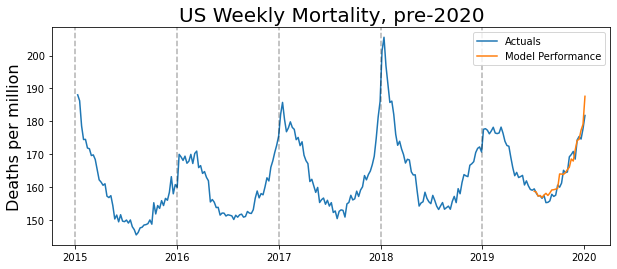

In [521]:
start_year = us_train['start_date'][0].year
end_year = us_train['end_date'][us_train.shape[0]-1].year

plt.figure(figsize=(10,4))
plt.plot(us_train.set_index('end_date')['deaths_per_mil'])
plt.plot(pd.DataFrame(us19_predictions).set_index(us_train.tail(len(y_test))['end_date']))
plt.title('US Weekly Mortality, pre-2020', fontsize=20)
plt.ylabel('Deaths per million', fontsize=16)
plt.legend(['Actuals', 'Model Performance'])
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.3)

# SARIMA, each state

In [474]:
# First, drop the last three weeks as they do not seem to be generally reliable
unreliable_data = test.iloc[:,-3:]
test.drop(columns = unreliable_data.columns, inplace = True)

In [478]:
# Create DataFrame
death_rate_change = pd.DataFrame(index=test.index, columns=['death_rate_change_per_mil'])

# Loop through state abbreviations
for state in train.index:
    try:
        # Best parameters from nation-wide gridsearch above
        my_order = (3,1,1)
        my_seasonal_order = (3, 1, 0, 52)

        model = SARIMAX(train.loc[state], order=my_order, seasonal_order=my_seasonal_order)

        sarima = model.fit()

        # forecast for 2020, get residuals
        predictions = sarima.forecast(len(test.T))
        residuals = test.loc[state] - predictions
        
        # calculate overall deviation from forecast and save to DataFrame
        change = np.mean(residuals)
        death_rate_change.loc[state] = change
        
        # save
        sarima.save(f'./data/pickles/{state}_sarima')
        
    except:
        pass
    
death_rate_change

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarn

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarn

C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
C:\Users\lafka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarn

,death_rate_change_per_mil
region_code,
AK,-4.53104
AL,-4.13449
AR,-3.05901
AZ,3.89358
CA,3.77528
CO,8.73387
CT,-56.8809
DC,8.08606
DE,-3.8229


## DRC histogram

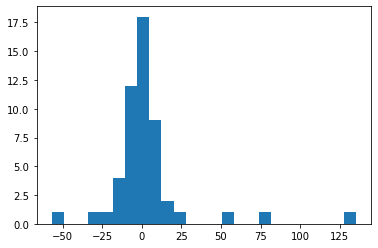

In [535]:
# Excepting New York City (outlier to the far right, every other point being a state or DC), data is pretty normal 
plt.hist(death_rate_change['death_rate_change_per_mil'], bins = 25);

In [451]:
# sarima.save(f'./data/pickles/{state}')
# sample = sm.load(f'./data/pickles/{state}')

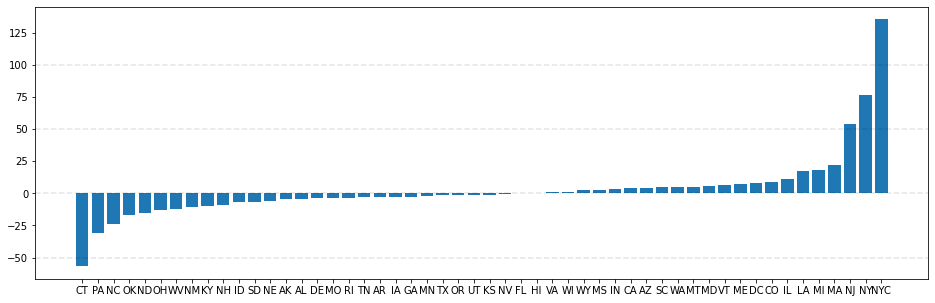

In [825]:
plt.figure(figsize=(16,5))

plt.bar(death_rate_change.sort_values('death_rate_change_per_mil').index, 
        death_rate_change.sort_values('death_rate_change_per_mil')['death_rate_change_per_mil'])

for i in [-50, 0, 50, 100]:
    plt.axhline(i, linestyle = '--', alpha = 0.1, color ='k');

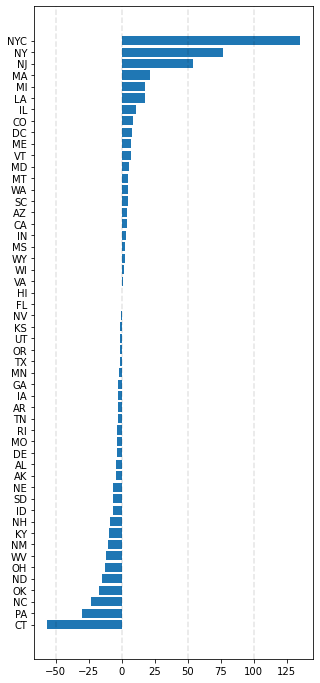

In [826]:
plt.figure(figsize=(5,12))

plt.barh(death_rate_change.sort_values('death_rate_change_per_mil').index, 
        death_rate_change.sort_values('death_rate_change_per_mil')['death_rate_change_per_mil'])

for i in [-50, 0, 50, 100]:
    plt.axvline(i, linestyle = '--', alpha = 0.1, color ='k');

In [788]:
death_rate_change.drop(index='NYC').to_csv('./data/death_rate_change.csv')

# Can we predict the change in death rate?

## Import state data

In [762]:
states = pd.read_csv('./data/states.csv', thousands = ',')

In [763]:
# make state a column to give pandas something to merge on
death_rate_change['state']=death_rate_change.index

In [764]:
# merge, dropping 'NYC' as it has no entry in states data
states = pd.merge(states, death_rate_change)

In [765]:
# reset index as state
states.set_index('state', inplace = True)

In [766]:
states['death_rate_change_per_mil'] = states['death_rate_change_per_mil'].astype(float)

In [835]:
# verify data is ready to go
states.dtypes

lat                          float64
long                         float64
household_income             float64
pop_dens                     float64
med_age                      float64
dem_governor                   int64
uninsured_rate               float64
lockdown_start               float64
is_coastal                     int64
death_rate_change_per_mil    float64
drc_sc                       float64
dtype: object

In [768]:
# Reformat 'governor' column into binary
states['governor'] = states['governor'].map({'R':0, 'D':1})
states.rename(columns={'governor' : 'dem_governor'}, inplace=True)

In [769]:
# Get scaled DRC for easy comparison
ss = StandardScaler()
states['drc_sc'] = ss.fit_transform(states[['death_rate_change_per_mil']])

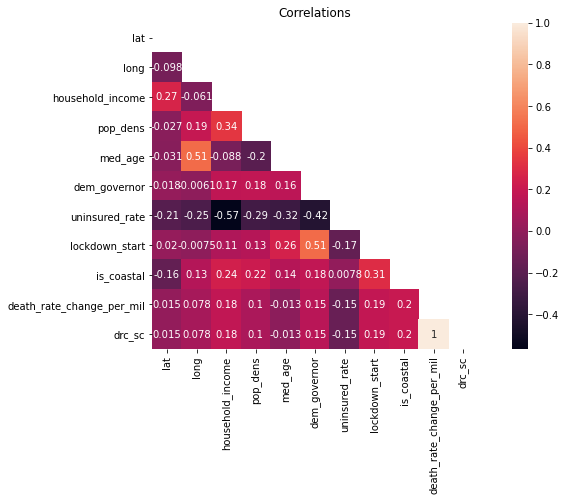

In [770]:
plt.figure(figsize=(12,6))
plt.title('Correlations')
mask = np.zeros_like(states.corr())
mask[np.triu_indices_from(mask)] = True

sb.heatmap(states.corr(), mask=mask, square=True, annot=True);

## Correlation heatmap with scaled DRC

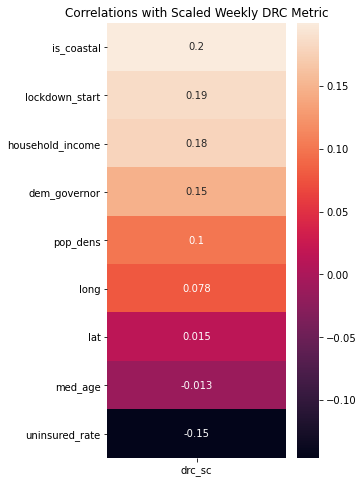

In [789]:
plt.figure(figsize = (4,8))
plt.title("Correlations with Scaled Weekly DRC Metric")
sb.heatmap(states.corr()[['drc_sc']].drop(['drc_sc','death_rate_change_per_mil'])
           .sort_values('drc_sc', ascending=False), annot=True);

## Pairplot

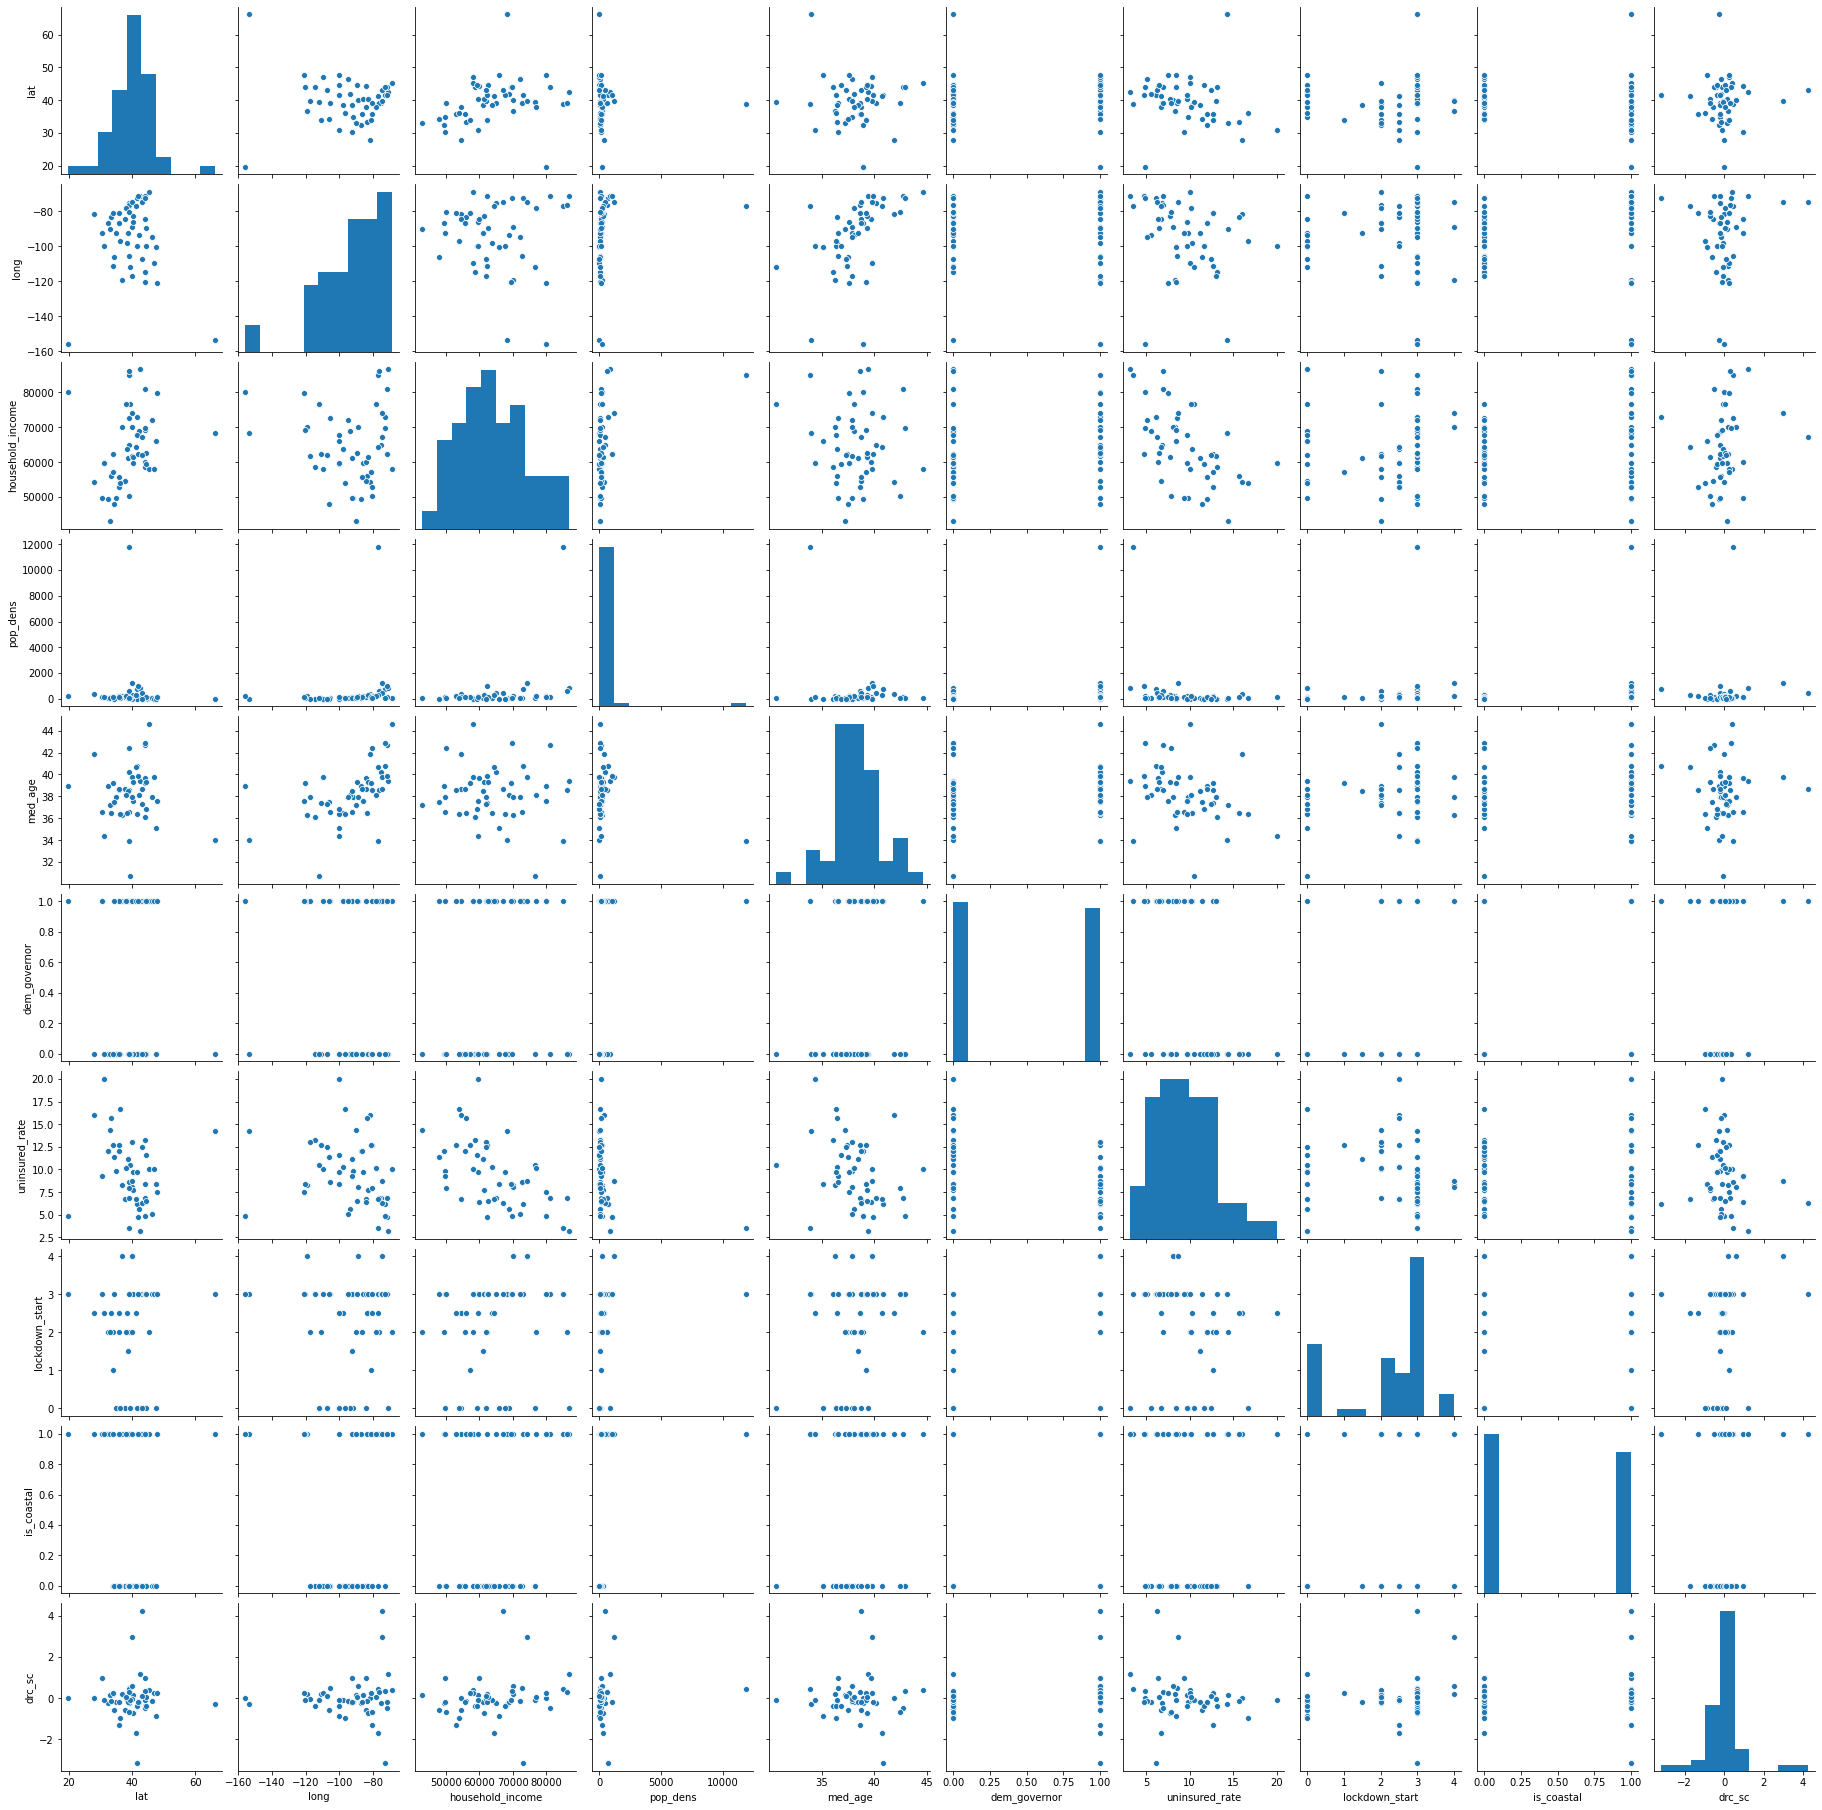

In [832]:
# Little correlation to speak of with death rate change
sb.pairplot(states.drop(columns = 'death_rate_change_per_mil'))

In [774]:
states

,lat,long,household_income,pop_dens,med_age,dem_governor,uninsured_rate,lockdown_start,is_coastal,death_rate_change_per_mil,drc_sc
state,,,,,,,,,,,
AK,66.160507,-153.369141,68400.0,1.3,34.0,0,14.3,3.0,1,-4.531045,-0.263672
AL,32.318230,-86.902298,49396.0,95.8,38.9,0,12.0,2.0,1,-4.134490,-0.241609
AR,34.799999,-92.199997,49778.0,57.2,37.9,0,9.8,0.0,0,-3.059006,-0.181773
AZ,34.048927,-111.093735,62311.0,60.1,37.4,0,12.7,2.0,0,3.893577,0.205044
CA,36.778259,-119.417931,70001.0,251.0,36.3,1,8.3,4.0,1,3.775279,0.198463
CO,39.113014,-105.358887,72620.0,52.6,36.6,1,8.6,3.0,0,8.733873,0.474342
CT,41.599998,-72.699997,73011.0,741.2,40.8,1,6.2,3.0,1,-56.880898,-3.176236
DC,38.897957,-77.036560,85101.0,11815.0,33.9,1,3.5,3.0,1,8.086064,0.438300
DE,39.000000,-75.500000,65002.0,484.1,40.2,1,6.8,3.0,1,-3.822899,-0.224273


## Model battery test

In [833]:
# Dropping CT as unreliable data
y = states.drop(index = 'CT')['death_rate_change_per_mil']
X = states.drop(index = 'CT', columns = ['death_rate_change_per_mil', 'drc_sc'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 20,
                                                   )


knn = Pipeline([
    ('ss', StandardScaler()),
    ('knr', KNeighborsRegressor())])
knn.fit(X_train, y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

svr = Pipeline([
    ('ss', StandardScaler()),
    ('supvec', SVR())])
svr.fit(X_train, y_train)
    
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
    
bag = BaggingRegressor()
bag.fit(X_train, y_train)

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
    
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)

print('Model Cross-reference, Root Mean Squared Error:\n')
print(f"knn_Train: {np.sqrt(mean_squared_error(knn.predict(X_train), y_train))}")
print(f"knn_Test: {np.sqrt(mean_squared_error(knn.predict(X_test), y_test))}\n")
print(f"lr_Train: {np.sqrt(mean_squared_error(lr.predict(X_train), y_train))}")
print(f"lr_Test: {np.sqrt(mean_squared_error(lr.predict(X_test), y_test))}\n")
print(f"svr_Train: {np.sqrt(mean_squared_error(svr.predict(X_train), y_train))}")
print(f"svr_Test: {np.sqrt(mean_squared_error(svr.predict(X_test), y_test))}\n")
print(f"dtr_Train: {np.sqrt(mean_squared_error(dtr.predict(X_train), y_train))}")
print(f"dtr_Test: {np.sqrt(mean_squared_error(dtr.predict(X_test), y_test))}\n")
print(f"bag_Train: {np.sqrt(mean_squared_error(bag.predict(X_train), y_train))}")
print(f"bag_Test: {np.sqrt(mean_squared_error(bag.predict(X_test), y_test))}\n")
print(f"rfr_Train: {np.sqrt(mean_squared_error(rfr.predict(X_train), y_train))}")
print(f"rfr_Test: {np.sqrt(mean_squared_error(rfr.predict(X_test), y_test))}\n")
print(f"ada_Train: {np.sqrt(mean_squared_error(ada.predict(X_train), y_train))}")
print(f"ada_Test: {np.sqrt(mean_squared_error(ada.predict(X_test), y_test))}\n")
print(f"base_Train: {np.sqrt(mean_squared_error([y.mean() for i in range(len(y_train))], y_train))}")
print(f"base_Test: {np.sqrt(mean_squared_error([y.mean() for i in range(len(y_test))], y_test))}\n")

Model Cross-reference, Root Mean Squared Error:

knn_Train: 16.48534502032152
knn_Test: 12.169518483656999

lr_Train: 16.16137778051616
lr_Test: 7.455422168399771

svr_Train: 18.01433586451746
svr_Test: 9.671712932927145

dtr_Train: 0.0
dtr_Test: 19.684305614620083

bag_Train: 8.229067735131911
bag_Test: 9.654860015123038

rfr_Train: 7.471223351459092
rfr_Test: 8.63815079726675

ada_Train: 4.750108784980037
ada_Test: 10.427485485259584

base_Train: 18.18911774866879
base_Test: 8.368297681739755



In [ ]:
# Change in death rate is not well-predicted by any of the features in this data set.